In [328]:
!pip install plotnine
!pip install geopandas
!pip install geopy

In [329]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
# from google.colab import drive
# drive.mount('/content/drive/',force_remount=True)

import pandas as pd
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
from numpy.random import default_rng
from plotnine import *
import time
import random

# import geopandas as gpd
# import geopy
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# import geopy.distance
# from shapely.geometry import Point, Polygon
# import plotly.express as px
from operator import add
import time

rng = default_rng(13)

In [330]:
# Colours
#
color_sunset_0 = '#4c2991'
color_sunset_1 = '#f6aa7a'
color_sunset_2 = '#fa7876'

In [331]:
# Modify this according to the path in your computer
main_dir = 'My Drive/Research/2023_OpenDRR/ACM7p0/'

#  <font color='orange'> Census data </font>

In [332]:
# https://www.publicsafety.gc.ca/cnt/mrgnc-mngmnt/rcvr-dsstrs/dsstr-fnncl-ssstnc-rrngmnts/index-en.aspx
theBCPopulation = 5368266
theBCMedianIncome = 69979 # https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=Province&GeographyId=59&CategoryLevel1=Population%2C%20Households%20and%20Housing%20Stock&CategoryLevel2=Household%20Income&ColumnField=HouseholdIncomeRange&RowField=MetropolitanMajorArea&SearchTags%5B0%5D.Key=Households&SearchTags%5B0%5D.Value=Number&SearchTags%5B1%5D.Key=Statistics&SearchTags%5B1%5D.Value=AverageAndMedian

In [333]:
# Recode
dict_region = {1:'Atlantic',
               2:'Quebec',
               3:'Ontario',
               4:'Praries',
               5:'British Columbia',
               6:'Territories'}

dict_mortgage = {1:'Yes',
                 2:'No',
                 6:'Valid skip',
                 9:'Not stated'}

dict_tenure = {1:'Yes',
               2:'No',
               9:'Not stated'}

In [334]:
df_CHS_raw = pd.read_csv('My Drive/Research/2023_OpenDRR/' + '2021_CHS_PUMF/Data/CHS2021ECL_PUMF.csv',index_col=None)
df_CHS = df_CHS_raw[['REGION','PDWLTYPE','PEHA_05A','PEHA_05B','PEHA_05C','PHHTTINC','PPAC_05','POWN_20','PDCT_05']].copy()
df_CHS.head(3)

,REGION,PDWLTYPE,PEHA_05A,PEHA_05B,PEHA_05C,PHHTTINC,PPAC_05,POWN_20,PDCT_05
0,1,1,2,2,2,75000,4,1,1
1,5,6,2,1,2,92500,4,6,2
2,4,1,2,1,2,60000,4,1,1


In [335]:
df_CHS['REGION'] = df_CHS['REGION'].map(dict_region)
df_CHS['POWN_20'] = df_CHS['POWN_20'].map(dict_mortgage)
df_CHS['PDCT_05'] = df_CHS['PDCT_05'].map(dict_tenure)

In [336]:
# Percentage with mortgage in BC
df_CHS_BC = df_CHS[df_CHS['REGION']=='British Columbia'].reset_index(drop=True).copy()
pctWithMortgage = df_CHS_BC[df_CHS_BC['POWN_20']=='Yes'].shape[0]/df_CHS_BC[df_CHS_BC['POWN_20'].isin(['Yes','No'])].shape[0]

/opt/anaconda3/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 71'. Pick better value with 'binwidth'.


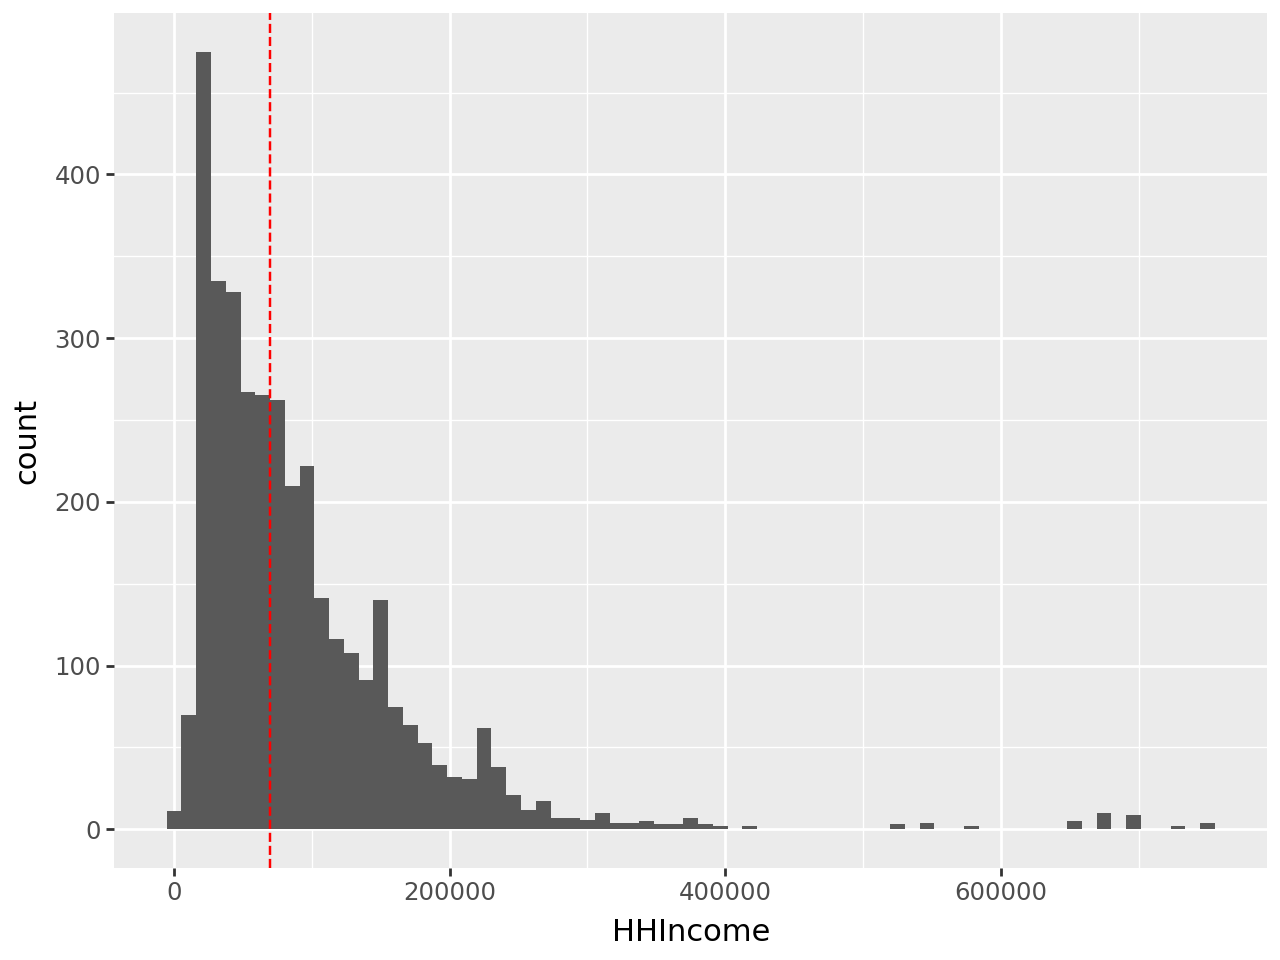

In [337]:
df_CHS_BC = df_CHS_BC.rename(columns={'PHHTTINC':'HHIncome','PDCT_05':'Owner'})
ggplot(df_CHS_BC[df_CHS_BC['HHIncome']<3000000],aes(x='HHIncome')) + geom_histogram() + geom_vline(xintercept = theBCMedianIncome,color='red',linetype='dashed')

In [338]:
theIncomeProbabilities = [df_CHS_BC[df_CHS_BC['HHIncome'] < 0.8 * theBCMedianIncome].shape[0]/df_CHS_BC.shape[0],
                          df_CHS_BC[(df_CHS_BC['HHIncome'] >= 0.8 * theBCMedianIncome) & (df_CHS_BC['HHIncome'] < 1.2 * theBCMedianIncome)].shape[0]/df_CHS_BC.shape[0],
                          df_CHS_BC[df_CHS_BC['HHIncome'] >= 1.2 * theBCMedianIncome].shape[0]/df_CHS_BC.shape[0]]

theIncomeProbabilities

[0.34048129616392664, 0.15153681200857755, 0.5079818918274959]

#  <font color='orange'> Prepare data </font>

##  <font color='orange'> Get damage and consequences </font>

In [339]:
# Read damage file
df_dmg_b0 = pd.read_csv(main_dir + 's_dmgbyasset_ACM7p0_GeorgiaStraitFault_b0_125_b.txt',index_col=None)
df_dmg_r1 = pd.read_csv(main_dir + 's_dmgbyasset_ACM7p0_GeorgiaStraitFault_r1_126_b.txt',index_col=None)


# Read consequence file
df_consequences_b0 = pd.read_csv(main_dir + 's_consequences_ACM7p0_GeorgiaStraitFault_b0_125_b.txt',index_col=None)
df_consequences_r1 = pd.read_csv(main_dir + 's_consequences_ACM7p0_GeorgiaStraitFault_r1_126_b.txt',index_col=None)

In [340]:
df_loss_b0 = pd.read_csv(main_dir + 's_lossesbyasset_ACM7p0_GeorgiaStraitFault_b0_127_b.txt',index_col=None)

In [341]:
df_loss_b0[(df_loss_b0['BldgType']=='W1') & (df_loss_b0['totalLoss']>0)][['nonstructural','structural','totalLoss']]#.sum()

,nonstructural,structural,totalLoss
4980,0.050082,95.499500,95.553851
4981,0.050082,95.499500,95.553851
4982,0.050082,95.499500,95.553851
4983,0.006407,74.551500,74.558608
4984,0.038319,156.876500,156.918521
...,...,...,...
274474,0.000000,15.664650,15.664650
274475,0.000000,125.317400,125.317400
274476,0.000000,109.652700,109.652700
274485,0.000000,15.273525,15.273525


##  <font color='orange'> Join damage and consequences </font>

In [342]:
df_main_r1 = df_dmg_r1[['structural~no_damage','structural~slight','structural~moderate','structural~extensive','structural~complete']]
df_main_r1.columns = ['structural~no_damage_r1','structural~slight_r1','structural~moderate_r1','structural~extensive_r1','structural~complete_r1']
df_main_r1.head(3)

,structural~no_damage_r1,structural~slight_r1,structural~moderate_r1,structural~extensive_r1,structural~complete_r1
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0


In [343]:
df_main_b0 = df_dmg_b0[['asset_id','lat','lon','BldEpoch','BldgType','EqDesLev','LandUse','OccClass','structural~no_damage','structural~slight','structural~moderate','structural~extensive','structural~complete']]\
            .join(df_consequences_b0[['number_of_buildings','value_structural','value_nonstructural','value_contents']])\
            .join(df_main_r1[['structural~no_damage_r1','structural~slight_r1','structural~moderate_r1','structural~extensive_r1','structural~complete_r1']])
df_main_b0.head(3)

,asset_id,lat,lon,BldEpoch,BldgType,EqDesLev,LandUse,OccClass,structural~no_damage,structural~slight,...,structural~complete,number_of_buildings,value_structural,value_nonstructural,value_contents,structural~no_damage_r1,structural~slight_r1,structural~moderate_r1,structural~extensive_r1,structural~complete_r1
0,10482-RES2-MH-LC,50.86109,-116.31034,2005-2016,MH,LC,RURAL,RES2,1.0,0.0,...,0.0,1.0,45312.5,135937.5,18125.0,1.0,0.0,0.0,0.0,0.0
1,10483-RES1-W1-LC,50.76687,-115.94197,Pre-1973,W1,LC,RURAL,RES1,1.0,0.0,...,0.0,1.0,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0
2,10484-RES1-W1-LC,50.76687,-115.94197,1990-2004,W1,LC,RURAL,RES1,1.0,0.0,...,0.0,1.0,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0


##  <font color='orange'> Residential buildings </font>

In [344]:
df_main_b0[df_main_b0['OccClass'] == 'RES1']['number_of_buildings'].sum() / df_main_b0[df_main_b0['OccClass'].isin(['RES1','RES2','RES3A','RES3B','RES3C','RES3D','RES3E','RES3F'])]['number_of_buildings'].sum()

0.7704174984906792

In [345]:
df_main_b0['ExposedValue'] = df_main_b0['value_structural'] * df_main_b0['number_of_buildings']
df_main_b0[df_main_b0['OccClass'] == 'RES1']['ExposedValue'].sum() / df_main_b0[df_main_b0['OccClass'].isin(['RES1','RES2','RES3A','RES3B','RES3C','RES3D','RES3E','RES3F'])]['ExposedValue'].sum()

0.8950630879809727

In [346]:
df_main_b0[df_main_b0['OccClass'] == 'RES1']['BldgType'].value_counts()/df_main_b0[df_main_b0['OccClass'] == 'RES1'].shape[0]

BldgType
W1      0.583711
W4      0.348804
URML    0.067485
Name: count, dtype: float64

In [347]:
df_RES1 = df_main_b0[df_main_b0['OccClass'] == 'RES1'].reset_index(drop=True).copy()
df_RES1.head(3)

,asset_id,lat,lon,BldEpoch,BldgType,EqDesLev,LandUse,OccClass,structural~no_damage,structural~slight,...,number_of_buildings,value_structural,value_nonstructural,value_contents,structural~no_damage_r1,structural~slight_r1,structural~moderate_r1,structural~extensive_r1,structural~complete_r1,ExposedValue
0,10483-RES1-W1-LC,50.76687,-115.94197,Pre-1973,W1,LC,RURAL,RES1,1.0,0.0,...,1.0,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5
1,10484-RES1-W1-LC,50.76687,-115.94197,1990-2004,W1,LC,RURAL,RES1,1.0,0.0,...,1.0,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5
2,10485-RES1-W4-PC,50.76687,-115.94197,Pre-1973,W4,PC,RURAL,RES1,1.0,0.0,...,1.0,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5


##  <font color='orange'> Residential buildings - damaged only </font>

In [348]:
df_RES1['AccumulatedDamage'] = df_RES1.loc[:,'structural~extensive':'structural~complete'].sum(axis=1)
#df_RES1 = df_RES1[df_RES1['AccumulatedDamage'] > 0].reset_index(drop=True).copy()
df_RES1.head(3)

,asset_id,lat,lon,BldEpoch,BldgType,EqDesLev,LandUse,OccClass,structural~no_damage,structural~slight,...,value_structural,value_nonstructural,value_contents,structural~no_damage_r1,structural~slight_r1,structural~moderate_r1,structural~extensive_r1,structural~complete_r1,ExposedValue,AccumulatedDamage
0,10483-RES1-W1-LC,50.76687,-115.94197,Pre-1973,W1,LC,RURAL,RES1,1.0,0.0,...,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5,0.0
1,10484-RES1-W1-LC,50.76687,-115.94197,1990-2004,W1,LC,RURAL,RES1,1.0,0.0,...,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5,0.0
2,10485-RES1-W4-PC,50.76687,-115.94197,Pre-1973,W4,PC,RURAL,RES1,1.0,0.0,...,81562.5,244687.5,32625.0,1.0,0.0,0.0,0.0,0.0,81562.5,0.0


##  <font color='orange'> Calculate unit characteristics </font>

In [349]:
# Structural value
df_RES1['value_structural'] = df_RES1['value_structural'] / df_RES1['number_of_buildings']


# Non-structural value
df_RES1['value_nonstructural'] = df_RES1['value_nonstructural'] / df_RES1['number_of_buildings']


# Value contents
df_RES1['value_contents'] = df_RES1['value_contents'] / df_RES1['number_of_buildings']


# Damage probabilities - baseline
df_RES1['structural~no_damage'] = df_RES1['structural~no_damage'] / df_RES1['number_of_buildings']
df_RES1['structural~slight'] = df_RES1['structural~slight'] / df_RES1['number_of_buildings']
df_RES1['structural~moderate'] = df_RES1['structural~moderate'] / df_RES1['number_of_buildings']
df_RES1['structural~extensive'] = df_RES1['structural~extensive'] / df_RES1['number_of_buildings']
df_RES1['structural~complete'] = df_RES1['structural~complete'] / df_RES1['number_of_buildings']


# Damage probabilities - retrofitted
df_RES1['structural~no_damage_r1'] = df_RES1['structural~no_damage_r1'] / df_RES1['number_of_buildings']
df_RES1['structural~slight_r1'] = df_RES1['structural~slight_r1'] / df_RES1['number_of_buildings']
df_RES1['structural~moderate_r1'] = df_RES1['structural~moderate_r1'] / df_RES1['number_of_buildings']
df_RES1['structural~extensive_r1'] = df_RES1['structural~extensive_r1'] / df_RES1['number_of_buildings']
df_RES1['structural~complete_r1'] = df_RES1['structural~complete_r1'] / df_RES1['number_of_buildings']


df_RES1['ProbDamage'] = df_RES1['structural~extensive'] + df_RES1['structural~complete']

df_RES1['ProbDamageb0'] = df_RES1['structural~moderate'] + df_RES1['structural~extensive'] + df_RES1['structural~complete']
df_RES1['ProbDamager1'] = df_RES1['structural~moderate_r1'] + df_RES1['structural~extensive_r1'] + df_RES1['structural~complete_r1']

df_RES1['RetrofitFlag'] = [True if df_RES1['ProbDamageb0'][i] > df_RES1['ProbDamager1'][i] else False for i in range(df_RES1.shape[0])]

##  <font color='orange'> Expand data frame so each row is one building </font>

In [350]:
df_SF_Complete = pd.DataFrame()

# Expand by repeating index multiple times
df_SF_Complete = df_RES1.loc[df_RES1.index.repeat(df_RES1.number_of_buildings)].reset_index(drop=True)
df_SF_Complete.head(1)

,asset_id,lat,lon,BldEpoch,BldgType,EqDesLev,LandUse,OccClass,structural~no_damage,structural~slight,...,structural~slight_r1,structural~moderate_r1,structural~extensive_r1,structural~complete_r1,ExposedValue,AccumulatedDamage,ProbDamage,ProbDamageb0,ProbDamager1,RetrofitFlag
0,10483-RES1-W1-LC,50.76687,-115.94197,Pre-1973,W1,LC,RURAL,RES1,1.0,0.0,...,0.0,0.0,0.0,0.0,81562.5,0.0,0.0,0.0,0.0,False


##  <font color='orange'> Replacement cost </font>

In [351]:
df_SF_Complete['ReplacementCost'] = df_SF_Complete['value_structural'] + df_SF_Complete['value_nonstructural']

##  <font color='orange'> Home value </font>

In [352]:
df_SF_Complete['HomeValue'] = df_SF_Complete['value_structural'] + df_SF_Complete['value_nonstructural']
df_SF_Complete['HomeValue'] = rng.lognormal(mean=np.log(1000000),sigma=0.2,size=df_SF_Complete.shape[0])

##  <font color='orange'> Mortgage status </font>

In [353]:
df_SF_Complete['Mortgage'] = rng.choice(p=[pctWithMortgage,1-pctWithMortgage],a=[1,0],size=df_SF_Complete.shape[0])

##  <font color='orange'> Equity </font>

In [354]:
df_SF_Complete['Equity'] = df_SF_Complete['Mortgage'] * rng.random(df_SF_Complete.shape[0])
df_SF_Complete['Equity'] = df_SF_Complete['Equity'].apply(lambda x: 0.2 + 0.8 * x) * df_SF_Complete['HomeValue']

##  <font color='orange'> Price to income ratio </font>

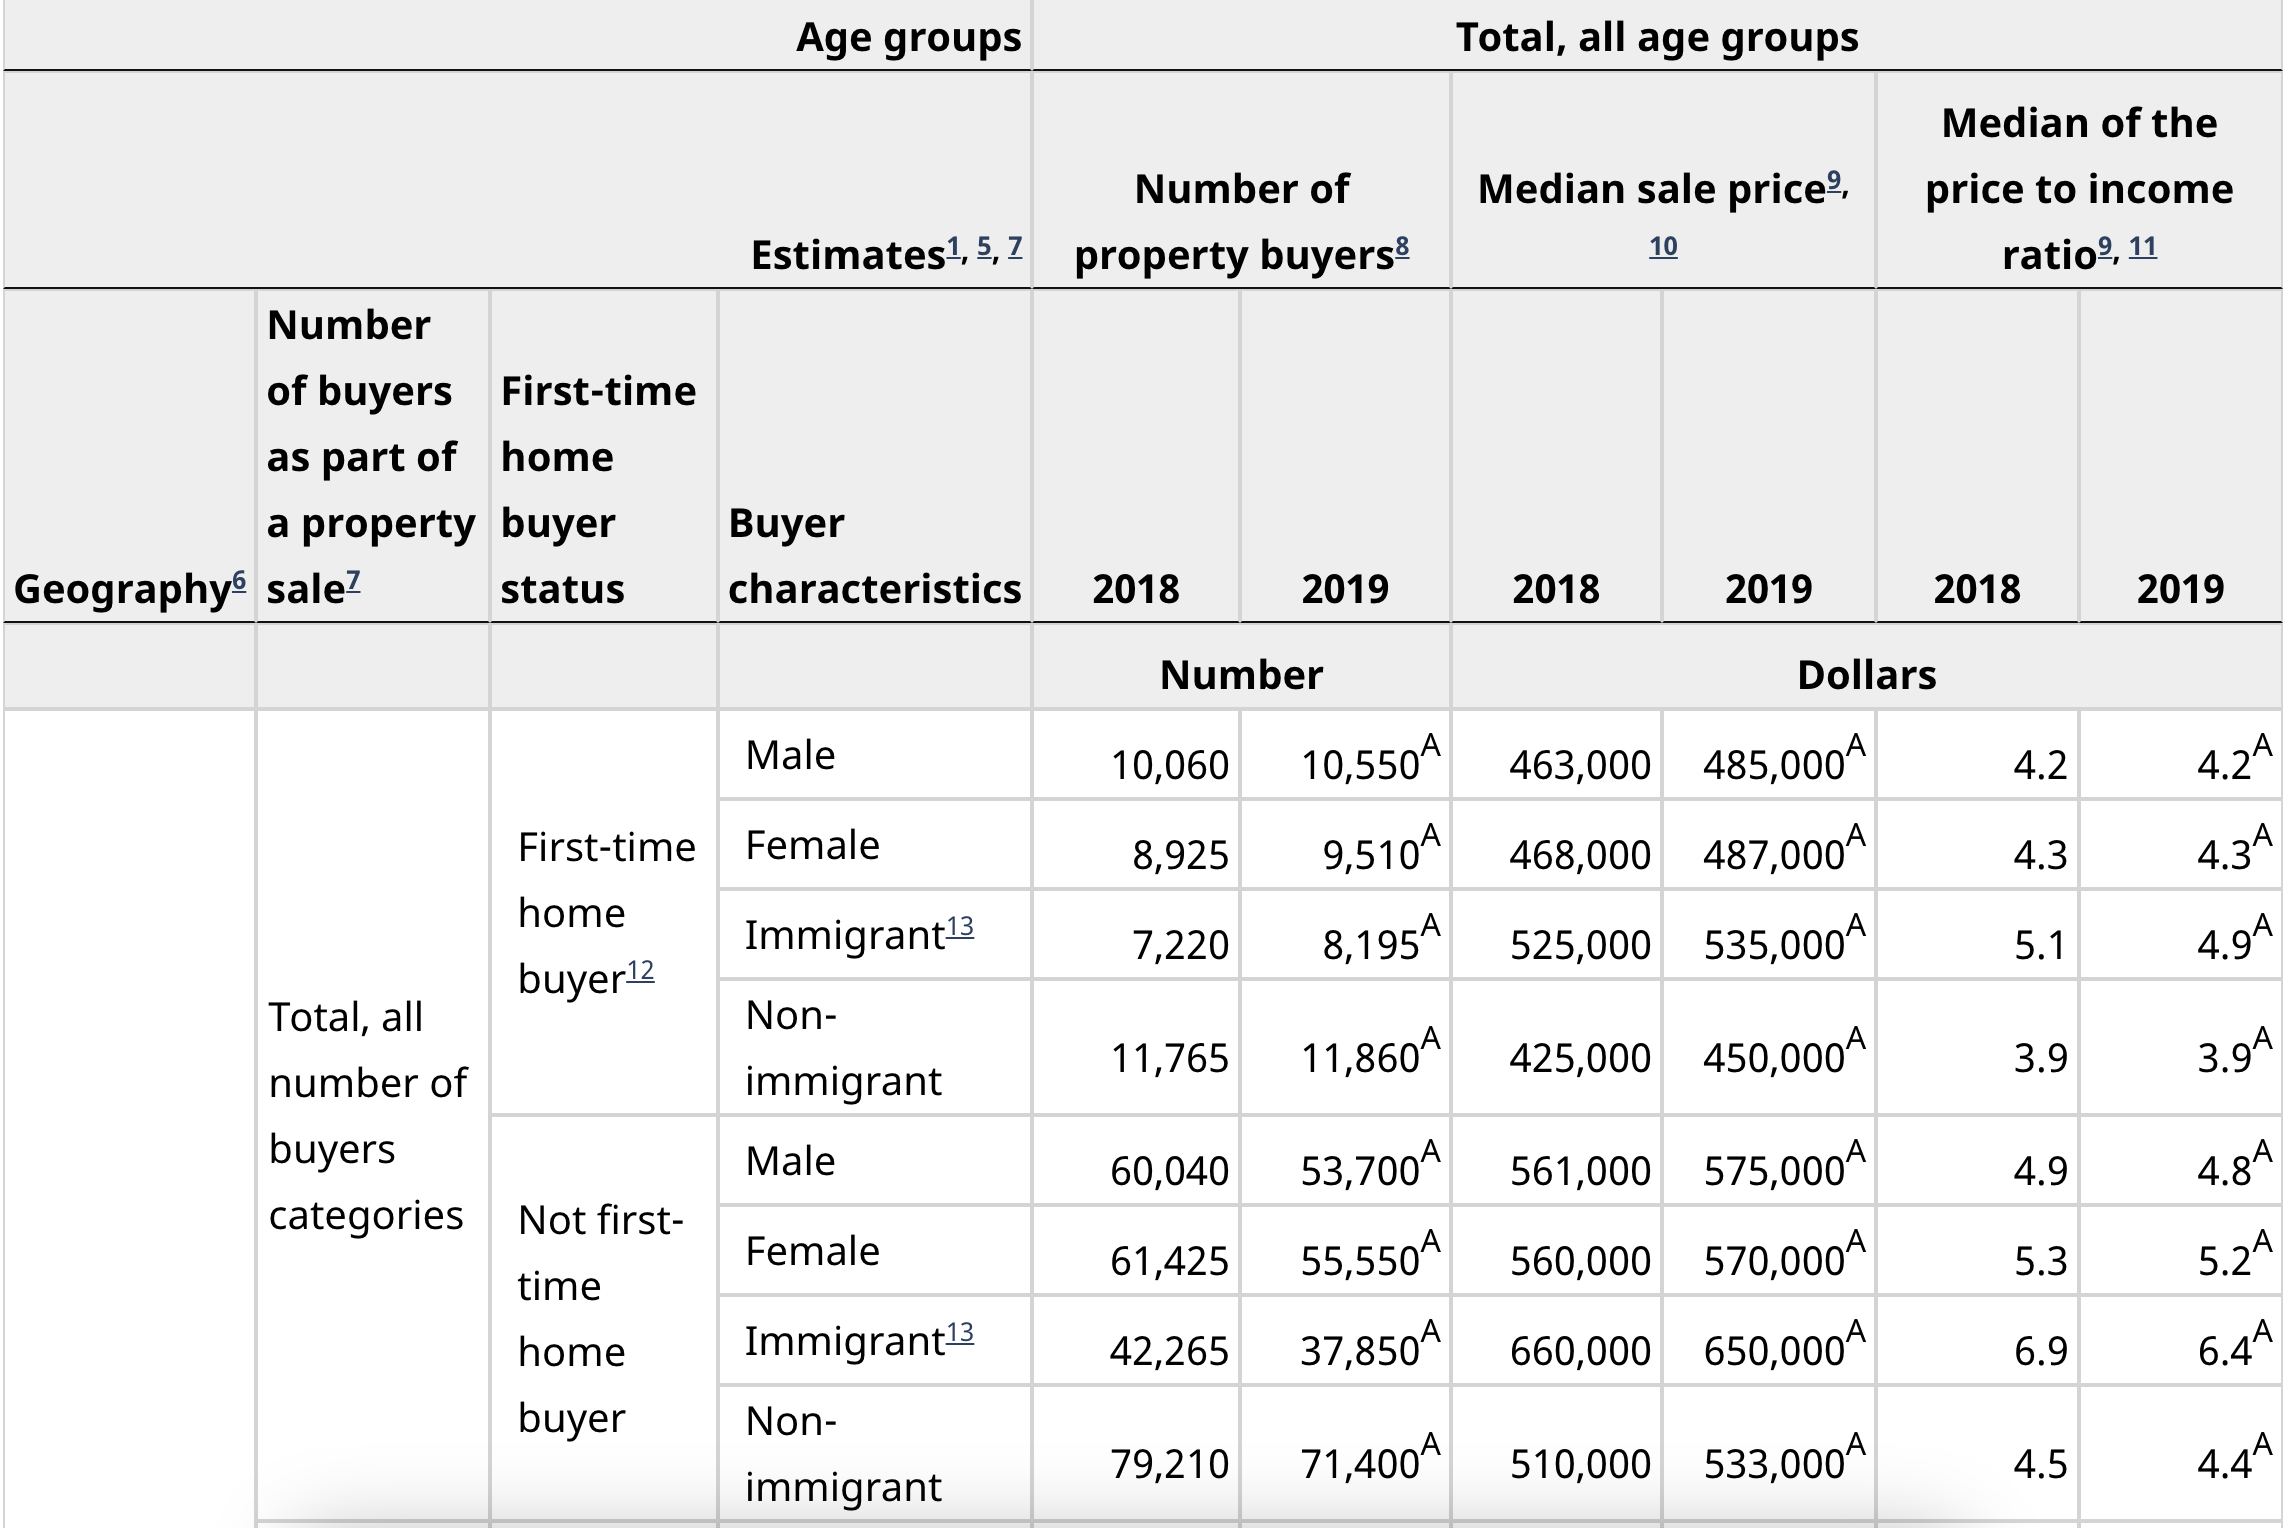

In [355]:
p = [10060,8925,60040,61425]
p = p/np.sum(p)

a = [4.2,4.3,4.8,5.2]

df_SF_Complete['Income'] = df_SF_Complete['HomeValue'] / rng.choice(a=a,p=p,size=df_SF_Complete.shape[0])
df_SF_Complete.hist('Income')

array([[<Axes: title={'center': 'Income'}>]], dtype=object)

/opt/anaconda3/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 379'. Pick better value with 'binwidth'.


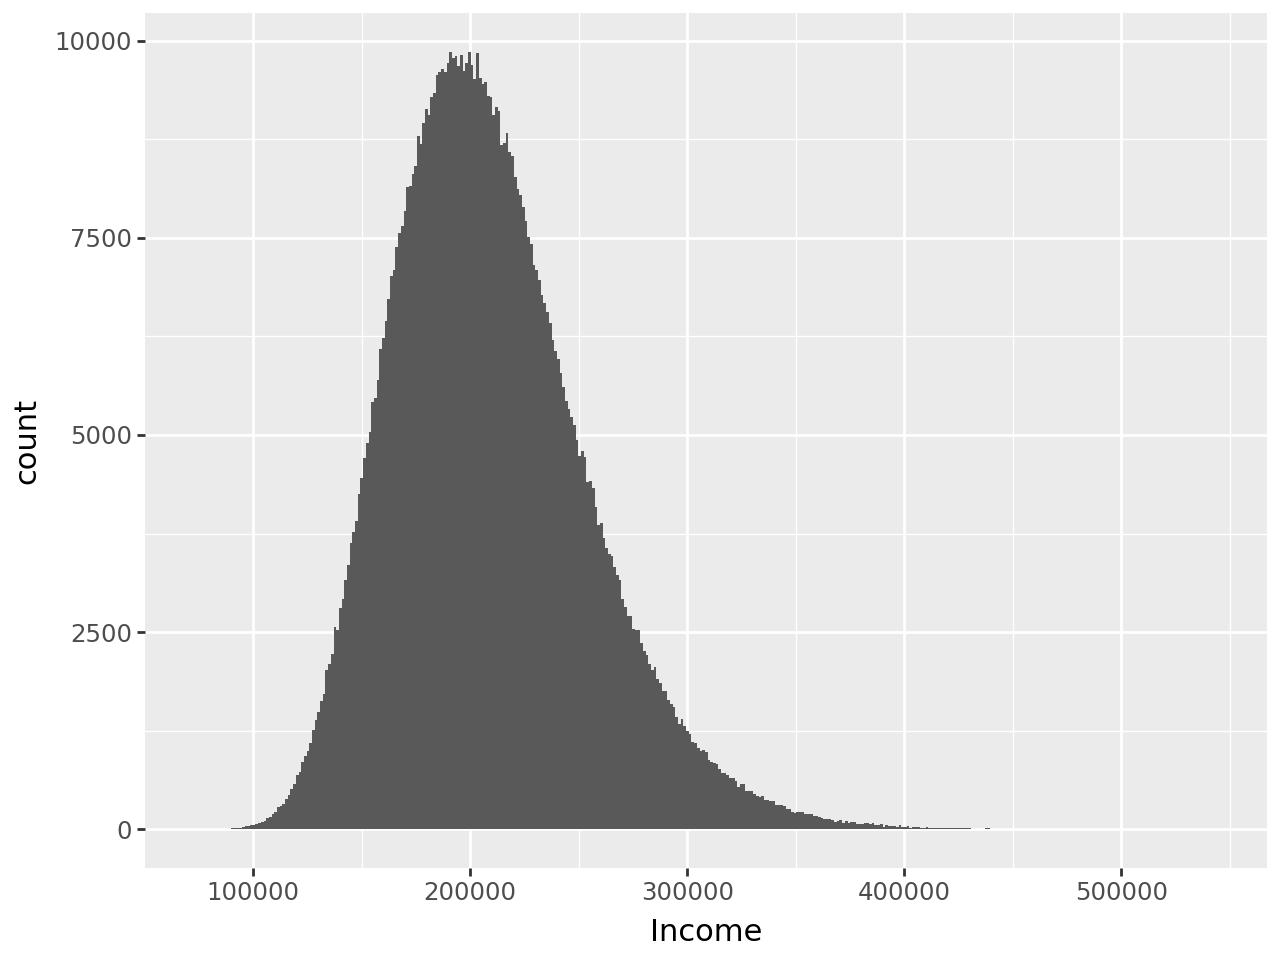

In [356]:
ggplot(df_SF_Complete,aes(x='Income')) + geom_histogram()

##  <font color='orange'> Jitter building location </font>

In [357]:
df_SF_Complete['lat'] = df_SF_Complete['lat'] - 0.001 + rng.random(size=df_SF_Complete.shape[0])*0.002
df_SF_Complete['lon'] = df_SF_Complete['lon'] - 0.001 + rng.random(size=df_SF_Complete.shape[0])*0.002

In [358]:
df_SF_Complete['HeavyDamage'] = df_SF_Complete['structural~moderate'] + df_SF_Complete['structural~extensive']+ df_SF_Complete['structural~complete']
df_plt = df_SF_Complete.copy()
df_plt = df_plt[df_plt['HeavyDamage']>0.01].reset_index(drop=True)
df_plt = df_plt[(df_plt['ProbDamage'] < np.percentile(df_plt['ProbDamage'],95)) &\
                        (df_plt['ProbDamage'] > np.percentile(df_plt['ProbDamage'],5))]

In [359]:
# gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.lon, df_plt.lat), crs='epsg:4326')
# fig = px.scatter_mapbox(gdf_plt,
#                         lat = gdf_plt['lat'],
#                         lon = gdf_plt['lon'],
#                         color='ProbDamage',
#                         opacity = 0.8,
#                         center={"lat": 49.216, "lon": -123.509},
#                         mapbox_style="open-street-map",
#                         color_continuous_scale='Sunsetdark',
#                         #hover_data = ['Units','Tenure'],
#                         zoom=7.7,
#                         height=700,
#                         width=800
#                       )
# fig.show()

In [360]:
# fig = px.scatter_mapbox(gdf_plt,
#                         lat = gdf_plt['lat'],
#                         lon = gdf_plt['lon'],
#                         color='ReplacementCost',
#                         opacity = 0.5,
#                         center={"lat": 49.216, "lon": -123.509},
#                         mapbox_style="open-street-map",
#                         color_continuous_scale='Sunsetdark',
#                         #hover_data = ['Units','Tenure'],
#                         zoom=7.7,
#                         height=700,
#                         width=800
#                       )
# fig.show()

#  <font color='orange'> Calculate uninsured losses </font>

In [362]:
nrealizations = 100
if 1 > 2:

    for batch in range(10):

        df_SF_Complete['HeavyDamage'] = df_SF_Complete['structural~moderate'] + df_SF_Complete['structural~extensive']+ df_SF_Complete['structural~complete']
        df_SF_Complete = df_SF_Complete[df_SF_Complete['HeavyDamage']>0.01].reset_index(drop=True).copy()
        df_SF = df_SF_Complete#.sample(10000).reset_index(drop=True).copy()

        dmg_states = [1,2,3,4,5]

        dict_DamageRealizations_b0 = {}
        dict_DamageRealizations_r1 = {}

        start = time.time()
        for i in range(df_SF.shape[0]):
            theRhos_b0 = []
            theRhos_r1 = []

            # Structural
            # https://github.com/NHERI-SimCenter/DamageAndLossModelLibrary/blob/a8cdc34e521dd9d43e3a126397d0d5b222777bac/data_sources/HAZUS_MH_5.1_EQ/hazus_data_eq.json#L887
            dmg_ratios = [0, 0, 2.0, 10.0, 44.7, 100.0]#[0,0,0.005,0.023,0.117,0.234]
            dmg_ratios = [d/dmg_ratios[-1] for d in dmg_ratios]
            dmg_ratios = [dmg_ratios[d] + rng.random()*(dmg_ratios[d+1] - dmg_ratios[d]) for d in range(5)]


            # Damage ratio - baseline
            rng = default_rng(13)
            p = [df_SF.loc[i,'structural~no_damage'],df_SF.loc[i,'structural~slight'],df_SF.loc[i,'structural~moderate'],df_SF.loc[i,'structural~extensive'],df_SF.loc[i,'structural~complete']]
            p = p / np.sum(p)
            theRhos_b0 = list(rng.choice(p=p,a=dmg_ratios,size=nrealizations))

            # Damage ratio - retrofitted
            rng = default_rng(13)
            p = [df_SF.loc[i,'structural~no_damage_r1'],df_SF.loc[i,'structural~slight_r1'],df_SF.loc[i,'structural~moderate_r1'],df_SF.loc[i,'structural~extensive_r1'],df_SF.loc[i,'structural~complete_r1']]
            p = p / np.sum(p)
            theRhos_r1 = list(rng.choice(p=p,a=dmg_ratios,size=nrealizations))

            dict_DamageRealizations_b0[i] = theRhos_b0
            dict_DamageRealizations_r1[i] = theRhos_r1

        df_DamageRealizations_b0 = pd.DataFrame.from_dict(dict_DamageRealizations_b0,orient='index',columns=['R'+str(i) for i in range(nrealizations)])
        df_DamageRealizations_r1 = pd.DataFrame.from_dict(dict_DamageRealizations_r1,orient='index',columns=['R'+str(i) for i in range(nrealizations)])

        end = time.time()
        print(end - start)

        df_DamageRealizations_b0.to_csv(main_dir + 'DamageRealizations_b0_batch' + str(batch) + '.csv',index=False)
        df_DamageRealizations_r1.to_csv(main_dir + 'DamageRealizations_r1_batch'+ str(batch) + '.csv',index=False)

# else:
#     df_DamageRealizations_b0 = pd.read_csv(main_dir + 'DamageRealizations_b0.csv')
#     df_DamageRealizations_r1= pd.read_csv(main_dir + 'DamageRealizations_r1.csv')

19.870336055755615
20.58847689628601
20.499922037124634
19.500338315963745
19.816969871520996
19.484868049621582
19.79119300842285
19.87191677093506
19.560968160629272
20.092363119125366


# Run scenario

In [363]:
# Insurance properties
theInsurancePenetrationRate = 0.65
theInsuranceDeductible = 0.125 # https://content.naic.org/sites/default/files/inline-files/JIR-ZA-39-11-EL.pdf
theInsuranceCoverage = 1 - theInsuranceDeductible

In [364]:
if 1 > 2:

    uhn_Baseline = []
    uhn_LowToMod = []
    uhn_Retrofitted = []
    uhn_Loans = []
    uhn_Parametric = []
    uhn_EQC = []
    uhn_All = []
    uhn_DFAA50 = []
    uhn_DFAA100 = []
    uhn_DFAA150 = []
    costs_losses = []
    costs_Loans = []
    costs_EQC = []
    cost_All = []
    benefit_Retrofitted = []


    df_SF_Complete['HeavyDamage'] = df_SF_Complete['structural~moderate'] + df_SF_Complete['structural~extensive']+ df_SF_Complete['structural~complete']
    df_SF_Complete = df_SF_Complete[df_SF_Complete['HeavyDamage']>0.01].reset_index(drop=True).copy()
    df_SF = df_SF_Complete


    for batch in range(10):
        print('Working on batch', batch)
        df_DamageRealizations_b0 = pd.read_csv(main_dir + 'DamageRealizations_b0_batch' + str(batch) + '.csv')
        df_DamageRealizations_r1= pd.read_csv(main_dir + 'DamageRealizations_r1_batch' + str(batch) + '.csv')


        start = time.time()

        for r in range(nrealizations):
            theRealization = 'B' + str(batch) +'R' + str(r)
            print(theRealization)

            theRhos_b0 = df_DamageRealizations_b0['R'+str(r)]
            theRhos_r1 = df_DamageRealizations_r1['R'+str(r)]

            # No retrofits
            # ----------------------------------------------------------
            df_SF['DamageRatio'] = theRhos_b0
            df_SF['RepairCost'] = df_SF['DamageRatio'] * df_SF['ReplacementCost']
            costs_losses.append(df_SF['RepairCost'].fillna(0).sum())


            # Set insurance status
            df_SF['InsuranceStatus'] = rng.choice(p=[theInsurancePenetrationRate,1-theInsurancePenetrationRate],a=[1,0],size=df_SF.shape[0])


            # Set loss threshold
            df_SF['LossThreshold'] = df_SF['RepairCost'] > df_SF['ReplacementCost'].multiply(theInsuranceDeductible)
            df_SF['LossThresholdParametric'] = df_SF['RepairCost'] > 0


            # Calculate insured losses with regular insurance
            df_SF['InsuredLosses'] = df_SF['LossThreshold'] * df_SF['InsuranceStatus'] * df_SF['RepairCost'] - df_SF['ReplacementCost'].multiply(theInsuranceDeductible)
            df_SF['InsuredLosses'] = df_SF['InsuredLosses'].apply(lambda x: np.maximum(x,0))

            # Calculate unmet needs - This is what Fed Government cares about
            df_SF['UnmetNeeds'] = df_SF['RepairCost'] - df_SF['InsuredLosses']
            uhn_Baseline.append(df_SF['UnmetNeeds'].fillna(0).sum())
            #uhn_LowToMod.append(df_SF[df_SF['Income'] != 'High']['UnmetNeeds'].apply(lambda x: np.minimum(x,150000)).fillna(0).sum())
            uhn_DFAA50.append(df_SF[(df_SF['Income'] != 'High') & (df_SF['UnmetNeeds']<50000)].shape[0]/df_SF.shape[0])
            uhn_DFAA100.append(df_SF[(df_SF['Income'] != 'High') & (df_SF['UnmetNeeds']<100000)].shape[0]/df_SF.shape[0])
            uhn_DFAA150.append(df_SF[(df_SF['Income'] != 'High') & (df_SF['UnmetNeeds']<150000)].shape[0]/df_SF.shape[0])

            # Introduce a low-interest loan program
            df_SF['MaxLoanByLoss'] = df_SF['RepairCost'].apply(lambda x: 0.4692 * x + 1891.9) # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044
            df_SF['MaxLoan'] = np.minimum(df_SF['RepairCost'] - df_SF['InsuredLosses'],df_SF['MaxLoanByLoss'])
            df_SF['UnmetNeedsLoan'] = np.maximum(df_SF['RepairCost'] - df_SF['InsuredLosses'] - df_SF['MaxLoan'],0)
            uhn_Loans.append(df_SF['UnmetNeedsLoan'].fillna(0).sum())
            costs_Loans.append(df_SF['MaxLoan'].fillna(0).sum())


            # Introduce EQC-like insurance program
            df_SF['EQCInsuredLosses'] = df_SF['RepairCost'].apply(lambda x: np.minimum(x,300000)).apply(lambda x: np.maximum(np.minimum(x*0.99,x-200),0))
            df_SF['EQCInsuredLosses'] = np.minimum(df_SF['EQCInsuredLosses'],df_SF['RepairCost'])
            df_SF['UnmetNeedsEQC'] = np.maximum(df_SF['RepairCost'] - df_SF['EQCInsuredLosses'],0)
            uhn_EQC.append(df_SF['UnmetNeedsEQC'].fillna(0).sum())
            costs_EQC.append(df_SF['EQCInsuredLosses'].fillna(0).sum())


            # Calculate debt - This is what homeowners perceive
            # df_SF['DebtBaseline'] = [i * (0.08/12*(1+0.08/12)**360)/((1+0.08/12)**360-1) * 360 for i in df_SF['UnmetNeeds']]
            # df_SF['DebtLoan'] = list(map(add,[i * (0.04/12*(1+0.04/12)**360)/((1+0.04/12)**360-1) * 360 for i in df_SF['MaxLoan']], [i * (0.08/12*(1+0.08/12)**360)/((1+0.08/12)**360-1) * 360 for i in df_SF['UnmetNeedsLoan']]))

            # With retrofits
            # ----------------------------------------------------------
            df_SF['DamageRatio_r1'] = theRhos_r1
            df_SF['RepairCost_r1'] = df_SF['DamageRatio_r1'] * df_SF['ReplacementCost']

            # Set loss threshold
            df_SF['LossThreshold'] = df_SF['RepairCost_r1'] > df_SF['ReplacementCost'].multiply(theInsuranceDeductible)
            df_SF['LossThresholdParametric'] = df_SF['RepairCost_r1'] > 0

            # Calculate insured losses with regular insurance
            df_SF['InsuredLosses_r1'] = df_SF['LossThreshold'] * df_SF['InsuranceStatus'] * df_SF['RepairCost_r1'] - df_SF['ReplacementCost'].multiply(theInsuranceDeductible)
            df_SF['InsuredLosses_r1'] = df_SF['InsuredLosses_r1'].apply(lambda x: np.maximum(x,0))


            # Calculate unmet needs - This is what Fed Government cares about
            df_SF['UnmetNeeds_r1'] = df_SF['RepairCost_r1'] - df_SF['InsuredLosses_r1']
            uhn_Retrofitted.append(df_SF['UnmetNeeds_r1'].fillna(0).sum())

            benefit_Retrofitted.append(df_SF['UnmetNeeds'] - df_SF['UnmetNeeds_r1'].fillna(0).sum())


            # Combination
            ## EQC
            df_SF['EQCInsuredLosses'] = df_SF['RepairCost_r1'].apply(lambda x: np.minimum(x,300000)).apply(lambda x: np.maximum(np.minimum(x*0.99,x-200),0))

            ## Loan
            df_SF['MaxLoanByLoss'] = df_SF['RepairCost_r1'].apply(lambda x: 0.4692 * x + 1891.9) # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044
            df_SF['MaxLoan'] = np.minimum(df_SF['RepairCost_r1'] - df_SF['EQCInsuredLosses'],df_SF['MaxLoanByLoss'])

            ## DFAA
            df_SF['UnmetNeedsCombined'] = np.maximum(df_SF['RepairCost_r1'] - df_SF['EQCInsuredLosses'] - df_SF['MaxLoan'],0)
            uhn_All.append(df_SF['UnmetNeedsCombined'].fillna(0).sum())

            df_SF['CostAll'] = df_SF['EQCInsuredLosses'] + df_SF['MaxLoan']
            cost_All.append(df_SF['CostAll'].fillna(0).sum())


    df_Scenario_UHN = pd.DataFrame()
    df_Scenario_UHN['Baseline'] = uhn_Baseline#.fillna(0).sum()
    df_Scenario_UHN['uhn_DFAA50'] = uhn_DFAA50#.fillna(0).sum()
    df_Scenario_UHN['uhn_DFAA100'] = uhn_DFAA100#.fillna(0).sum()
    df_Scenario_UHN['uhn_DFAA150'] = uhn_DFAA150#.fillna(0).sum()
    df_Scenario_UHN['Loans'] = uhn_Loans#.fillna(0).sum()
    df_Scenario_UHN['Retrofit'] = uhn_Retrofitted#.fillna(0).sum()
    df_Scenario_UHN['EQC'] = uhn_EQC#.fillna(0).sum()
    df_Scenario_UHN['Combined'] = uhn_All
    df_Scenario_UHN = df_Scenario_UHN.reset_index(drop=True)

    df_Scenario_costs = pd.DataFrame()
    df_Scenario_costs['Losses'] = costs_losses#.fillna(0).sum()
    df_Scenario_costs['Loans'] = costs_Loans#.fillna(0).sum()
    df_Scenario_costs['EQC'] = costs_EQC#.fillna(0).sum()
    df_Scenario_costs['Combined'] = cost_All
    df_Scenario_costs = df_Scenario_costs.reset_index(drop=True)

    df_Scenario_benefits = pd.DataFrame()
    df_Scenario_benefits['Retrofits'] = benefit_Retrofitted#.fillna(0).mean()
    df_Scenario_benefits = df_Scenario_benefits.reset_index(drop=True)

    df_Scenario_UHN.to_csv(main_dir + 'df_Scenarios_UHN.csv',index=False)
    df_Scenario_costs.to_csv(main_dir + 'df_Scenarios_Costs.csv',index=False)
    df_Scenario_benefits.to_csv(main_dir + 'df_Scenarios_Benefits.csv',index=False)

Working on batch 0
B0R0
B0R1
B0R2
B0R3
B0R4
B0R5
B0R6
B0R7
B0R8
B0R9
B0R10
B0R11
B0R12
B0R13
B0R14
B0R15
B0R16
B0R17
B0R18
B0R19
B0R20
B0R21
B0R22
B0R23
B0R24
B0R25
B0R26
B0R27
B0R28
B0R29
B0R30
B0R31
B0R32
B0R33
B0R34
B0R35
B0R36
B0R37
B0R38
B0R39
B0R40
B0R41
B0R42
B0R43
B0R44
B0R45
B0R46
B0R47
B0R48
B0R49
B0R50
B0R51
B0R52
B0R53
B0R54
B0R55
B0R56
B0R57
B0R58
B0R59
B0R60
B0R61
B0R62
B0R63
B0R64
B0R65
B0R66
B0R67
B0R68
B0R69
B0R70
B0R71
B0R72
B0R73
B0R74
B0R75
B0R76
B0R77
B0R78
B0R79
B0R80
B0R81
B0R82
B0R83
B0R84
B0R85
B0R86
B0R87
B0R88
B0R89
B0R90
B0R91
B0R92
B0R93
B0R94
B0R95
B0R96
B0R97
B0R98
B0R99
Working on batch 1
B1R0
B1R1
B1R2
B1R3
B1R4
B1R5
B1R6
B1R7
B1R8
B1R9
B1R10
B1R11
B1R12
B1R13
B1R14
B1R15
B1R16
B1R17
B1R18
B1R19
B1R20
B1R21
B1R22
B1R23
B1R24
B1R25
B1R26
B1R27
B1R28
B1R29
B1R30
B1R31
B1R32
B1R33
B1R34
B1R35
B1R36
B1R37
B1R38
B1R39
B1R40
B1R41
B1R42
B1R43
B1R44
B1R45
B1R46
B1R47
B1R48
B1R49
B1R50
B1R51
B1R52
B1R53
B1R54
B1R55
B1R56
B1R57
B1R58
B1R59
B1R60
B1R61
B1R62
B1R6

In [365]:
df_Scenario_UHN = pd.read_csv(main_dir + 'df_Scenarios_UHN.csv')
df_Scenario_costs = pd.read_csv(main_dir + 'df_Scenarios_Costs.csv')
df_Scenario_benefits = pd.read_csv(main_dir + 'df_Scenarios_Benefits.csv')

df_SF_Complete['HeavyDamage'] = df_SF_Complete['structural~moderate'] + df_SF_Complete['structural~extensive']+ df_SF_Complete['structural~complete']
df_SF = df_SF_Complete[df_SF_Complete['HeavyDamage']>0.01].reset_index(drop=True).copy()

#  <font color='orange'> Scenario results </font>

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


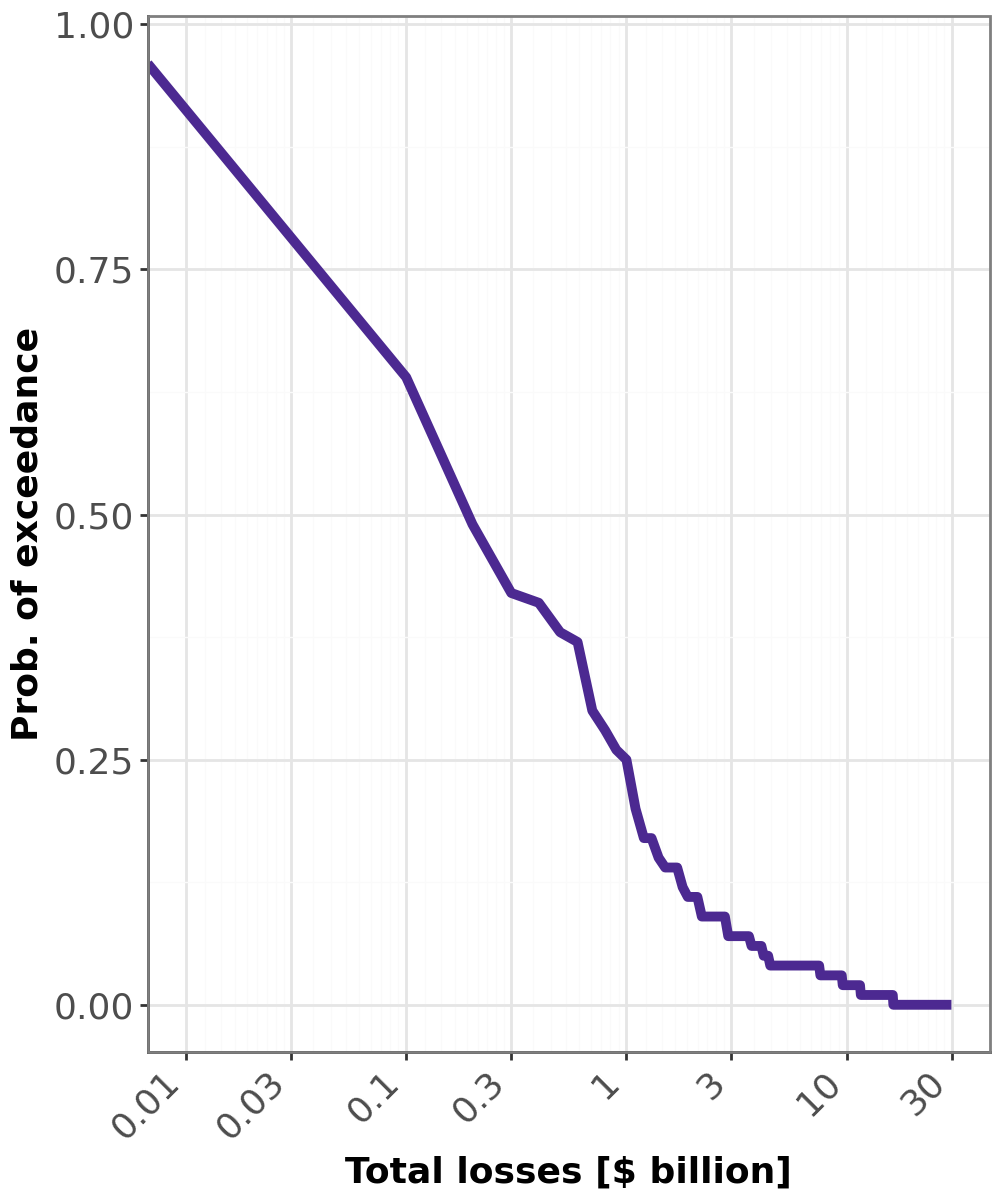

In [446]:
df_plot_loss = pd.DataFrame()

threshold = list(range(0,30*10**9,1*10**8))
v = []

for i in threshold:
    v.append(df_Scenario_costs[df_Scenario_costs['Losses']>i].shape[0]/df_Scenario_costs.shape[0])

df_plot_loss['Threshold'] = [i/10**9 for i in threshold]
df_plot_loss['Exceedance'] = v

plot_base = ggplot(df_plot_loss,aes(x='Threshold',y='Exceedance')) + geom_line(size=2,color=color_sunset_0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.83,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 6)) +\
        scale_fill_manual(values=[color_sunset_2]) +\
        scale_y_continuous(name = 'Prob. of exceedance') +\
        scale_x_log10(name = 'Total losses [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 140 rows containing missing values.


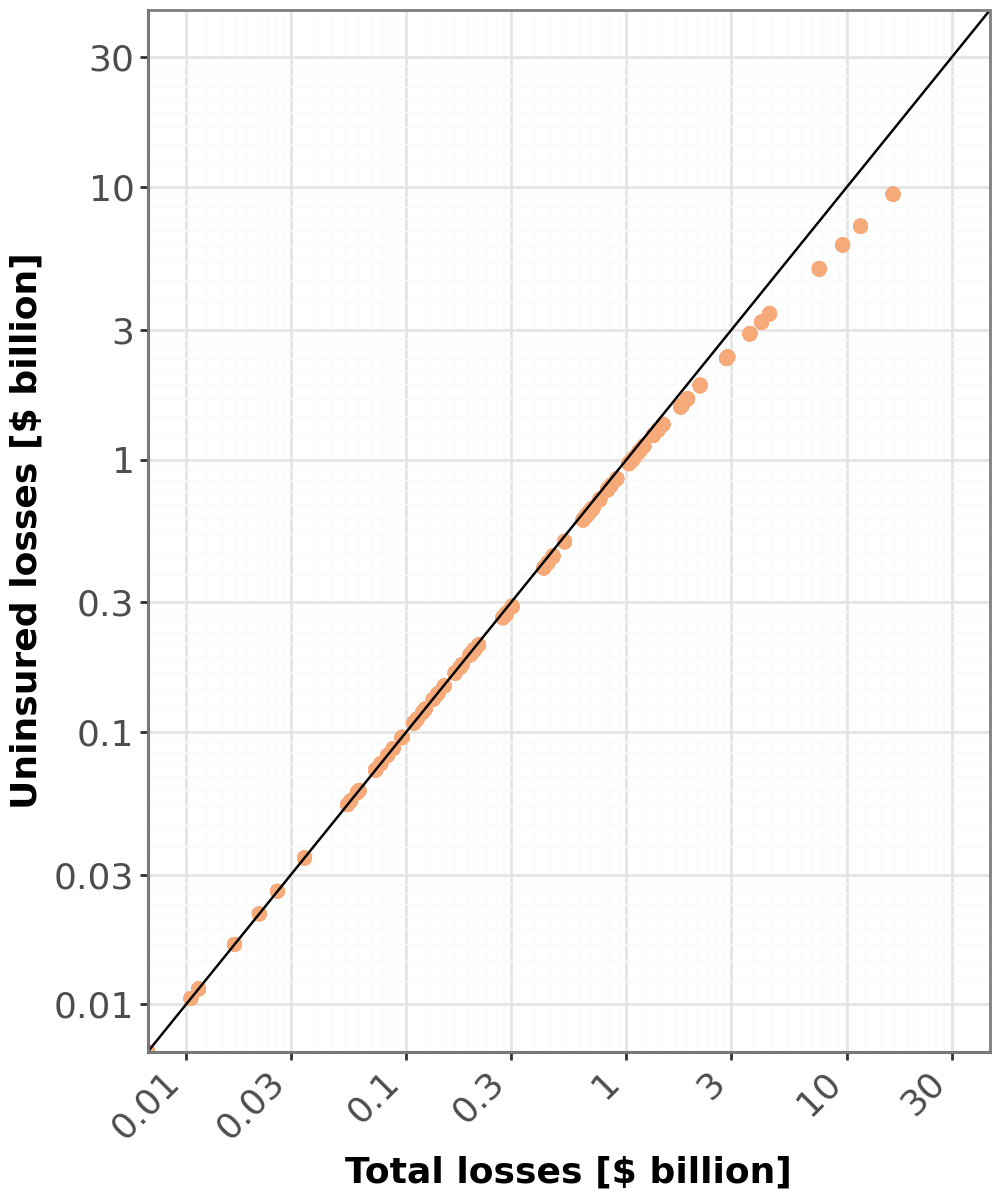

In [445]:
df_plot = pd.DataFrame()
df_plot['Total losses'] = df_Scenario_costs['Losses'].divide(10**9)
df_plot['Uninsured losses'] = df_Scenario_UHN['Baseline'].divide(10**9)
plot_base = ggplot(df_plot,aes(x='Total losses',y='Uninsured losses')) + geom_point(color=color_sunset_1,size=2) + geom_abline(slope=1)
plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.83,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 6)) +\
        scale_y_log10(name = 'Uninsured losses [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30]) +\
        scale_x_log10(name = 'Total losses [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

In [486]:
df_plot = df_Scenario_costs.copy()
df_plot['Losses'] = df_plot['Losses'].divide(df_SF.shape[0])
df_plot[df_plot['Losses']>0]['Losses'].median()
#np.percentile(df_plot['Losses'],95)

1367.698220607821

##  <font color='orange'> DFFA Expansion costs </font>

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 420 rows containing missing values.


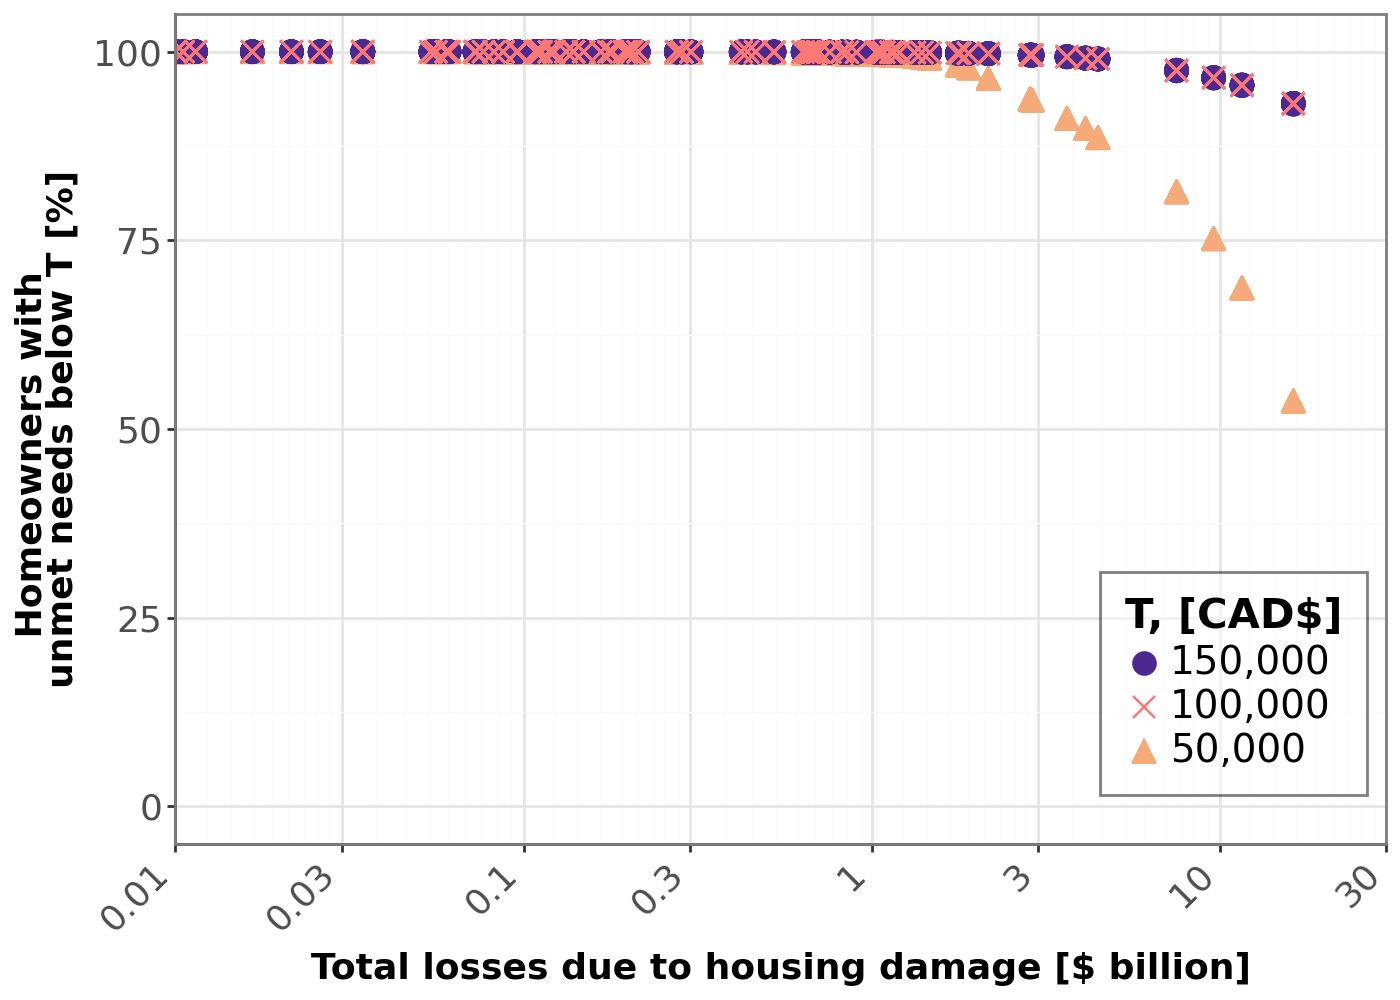

In [487]:
df_plot = df_Scenario_UHN[['uhn_DFAA50','uhn_DFAA100','uhn_DFAA150']].copy().rename(columns={'uhn_DFAA50':'50,000','uhn_DFAA100':'100,000','uhn_DFAA150':'150,000'})
df_plot['Losses'] = df_Scenario_costs['Losses'].divide(10**9)

df_plot_long = pd.melt(df_plot,id_vars='Losses')
df_plot_long['variable'] = pd.Categorical(df_plot_long['variable'] ,
                      categories=['150,000','100,000','50,000'],
                      ordered=True)

plot_base = ggplot(df_plot_long,aes(x='Losses',y='100*value',color='variable',shape='variable')) + geom_point(size=4)


plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.98,0.08),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(7, 5)) +\
        scale_shape_manual(name ='T, [CAD$]',values=['o','x','^']) +\
        scale_color_manual(name ='T, [CAD$]',values=[color_sunset_0,color_sunset_2,color_sunset_1]) +\
        scale_y_continuous(name = '    Homeowners with\nunmet needs below T [%]',expand=[0,5],limits=[0,100]) +\
        scale_x_log10(name = 'Total losses due to housing damage [$ billion]',expand=[0,0],limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

In [496]:
df_plot = df_Scenario_costs.copy()
df_plot[df_plot['Losses']>10**9].shape[0]/df_plot.shape[0]

0.25

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_46896/2550536787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


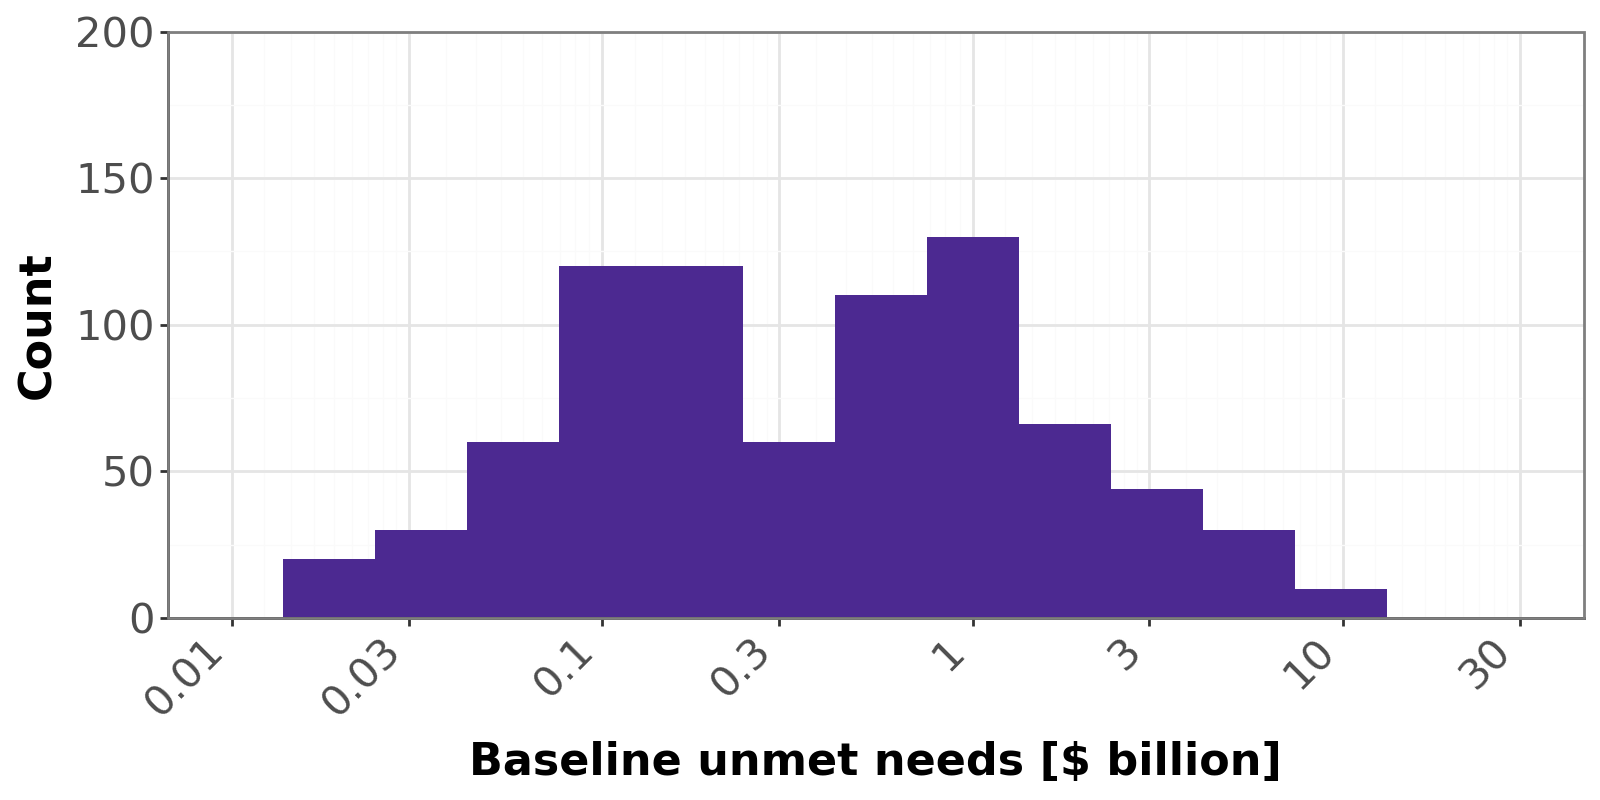

In [442]:
df_plot = df_Scenario_UHN[['Baseline']]
df_plot['Baseline'] = df_plot['Baseline'].divide(10**9)
plot_base = ggplot(df_plot,aes(x='Baseline')) + geom_histogram(fill=color_sunset_0,bins=15)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Baseline unmet needs [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean



---



##  <font color='orange'> Low-interest Loan Program</font>

In [371]:
# Costs of the low-interest loan program
rlow = 0.04/12
rhigh = 0.08/12
loanProgram_costs = df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rhigh*(1+rhigh)**360)/((1+rhigh)**360-1))\
                    - df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rlow*(1+rlow)**360)/((1+rlow)**360-1))

In [372]:
rlow = [0.01/12,0.02/12,0.03/12,0.04/12,0.05/12,0.06/12]
theCost = []
for i in range(len(rlow)):
    theCost.append(df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rhigh*(1+rhigh)**360)/((1+rhigh)**360-1))\
                    - df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rlow[i]*(1+rlow[i])**360)/((1+rlow[i])**360-1)))

df_DFAA_Loans = pd.DataFrame()
df_DFAA_Loans['r0.01'] = theCost[0]
df_DFAA_Loans['r0.02'] = theCost[1]
df_DFAA_Loans['r0.03'] = theCost[2]
df_DFAA_Loans['r0.04'] = theCost[3]
df_DFAA_Loans['r0.05'] = theCost[4]
df_DFAA_Loans['r0.06'] = theCost[5]

df_DFAA_Loans

,r0.01,r0.02,r0.03,r0.04,r0.05,r0.06
0,1.323501e+09,1.169418e+09,1.002474e+09,8.232415e+08,6.324637e+08,4.310157e+08
1,1.268217e+09,1.120570e+09,9.606000e+08,7.888541e+08,6.060452e+08,4.130119e+08
2,1.034855e+09,9.143759e+08,7.838415e+08,6.436983e+08,4.945278e+08,3.370142e+08
3,1.175212e+07,1.038393e+07,8.901544e+06,7.310034e+06,5.616009e+06,3.827236e+06
4,3.775855e+05,3.336267e+05,2.859988e+05,2.348650e+05,1.804375e+05,1.229658e+05
...,...,...,...,...,...,...
995,2.379111e+07,2.102133e+07,1.802037e+07,1.479850e+07,1.136910e+07,7.747894e+06
996,7.752409e+08,6.849867e+08,5.871995e+08,4.822140e+08,3.704658e+08,2.524676e+08
997,1.356683e+08,1.198736e+08,1.027607e+08,8.438813e+07,6.483204e+07,4.418219e+07
998,1.917475e+08,1.694241e+08,1.452375e+08,1.192704e+08,9.163072e+07,6.244514e+07


In [373]:
df_CBA_Loans = pd.DataFrame()
df_CBA_Loans['CBA0.1'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.01']
df_CBA_Loans['CBA0.2'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.02']
df_CBA_Loans['CBA0.3'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.03']
df_CBA_Loans['CBA0.4'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.04']
df_CBA_Loans['CBA0.5'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.05']
df_CBA_Loans['CBA0.6'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans'])/df_DFAA_Loans['r0.06']

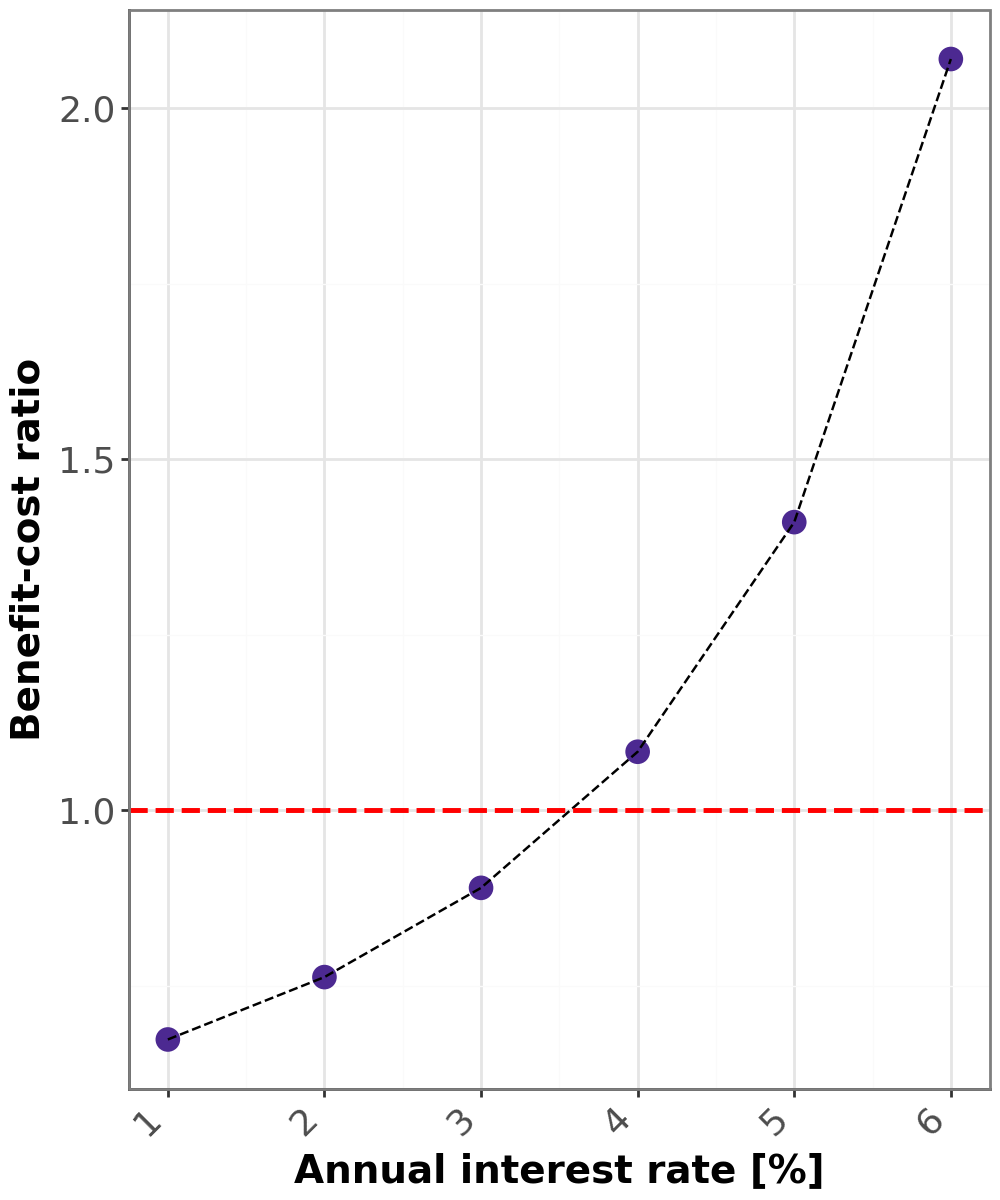

In [374]:
df_plot = pd.DataFrame()
df_plot['Interest'] = [0.01,0.02,0.03,0.04,0.05,0.06]
df_plot['Interest'] = df_plot['Interest'].multiply(100)
df_plot['CBA'] = list(df_CBA_Loans.loc[1])


plot_base = ggplot(df_plot,aes(x='Interest',y='CBA')) +\
   geom_point(size=4,color=color_sunset_0) + geom_line(linetype='dashed') +\
   geom_hline(yintercept = 1, linetype='dashed', color='red', size=1)


plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.24,0.85),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 6)) +\
        scale_color_manual(name = 'Legend',values=['black','orange']) +\
        scale_y_continuous(name = 'Benefit-cost ratio') +\
        scale_x_continuous(name = 'Annual interest rate [%]',breaks=range(0,7))

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 170 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


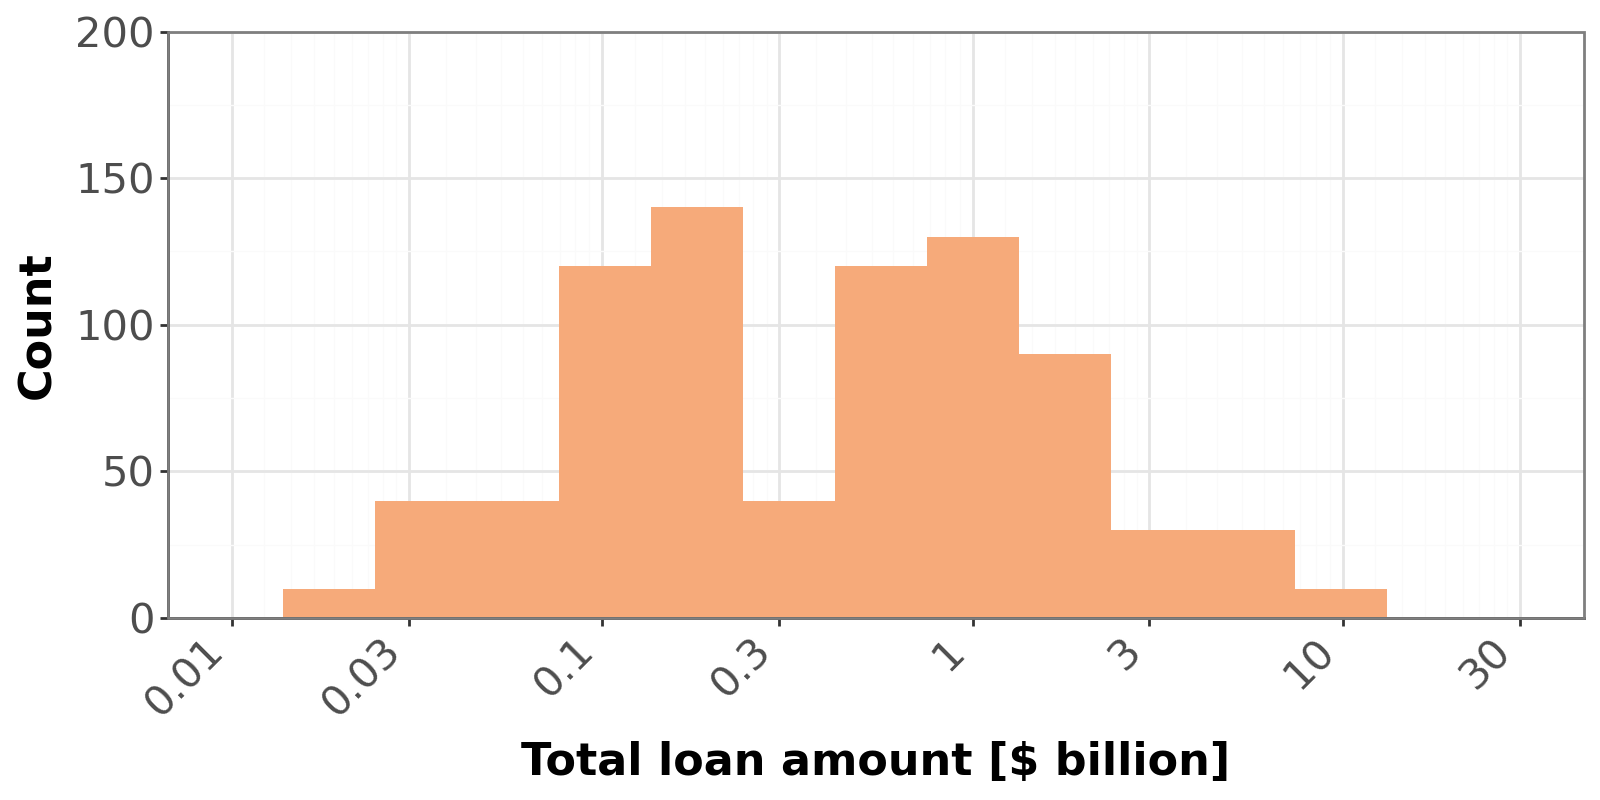

In [441]:
rlow = [0.03/12]
theCost = []
for i in range(len(rlow)):
    theCost.append(df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rlow[i]*(1+rlow[i])**360)/((1+rlow[i])**360-1)))

df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Expenditure'] = theCost[0]
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_plot['Expenditure']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Expenditure')) + geom_histogram(bins=15,fill=color_sunset_1)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Total loan amount [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 200 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


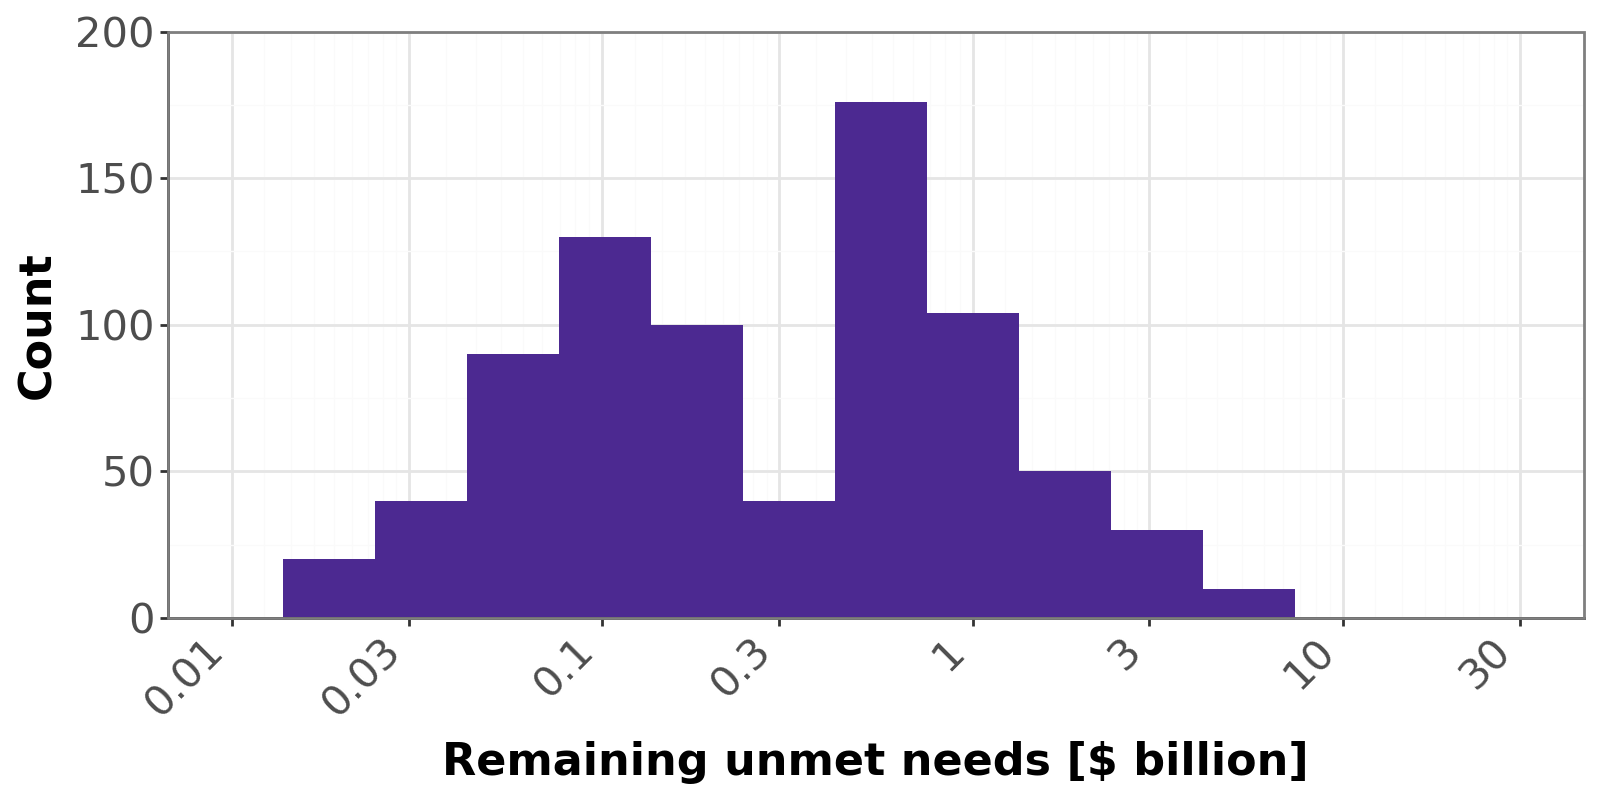

In [440]:
rlow = [0.03/12]
theCost = []
for i in range(len(rlow)):
    theCost.append(df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rlow[i]*(1+rlow[i])**360)/((1+rlow[i])**360-1)))

df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
#df_plot['Expenditure'] = theCost[0]
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Benefit')) + geom_histogram(bins=15,fill=color_sunset_0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Remaining unmet needs [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 380 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 3 rows containing missing values.


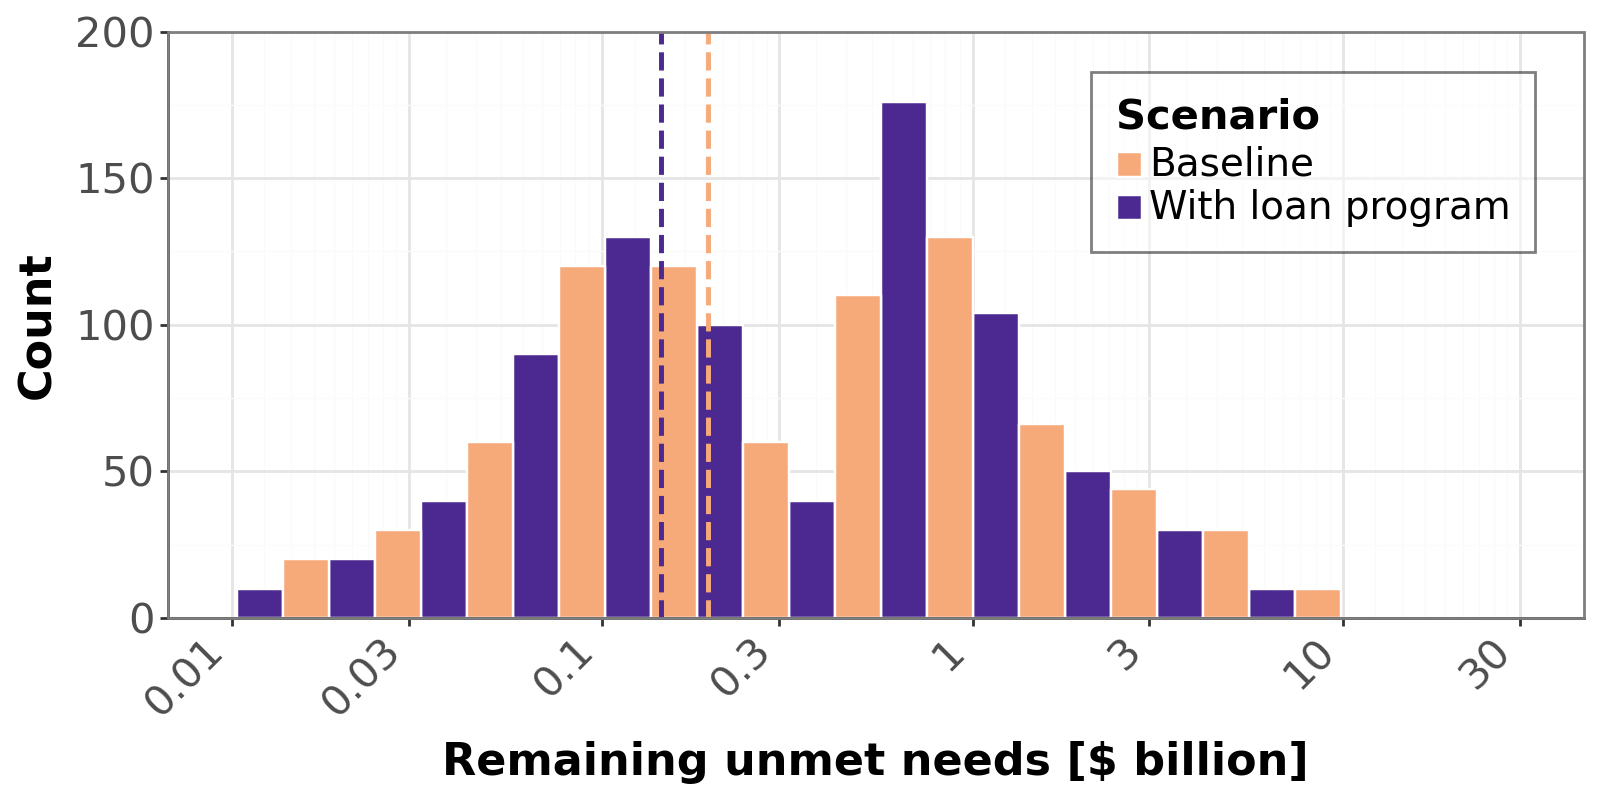

In [497]:
rlow = [0.03/12]
theCost = []
for i in range(len(rlow)):
    theCost.append(df_Scenario_costs['Loans'].apply(lambda x: 360 * x * (rlow[i]*(1+rlow[i])**360)/((1+rlow[i])**360-1)))

df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
#df_plot['Expenditure'] = theCost[0]
df_plot['With loan program'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Loans']
df_plot = df_plot.divide(10**9)

df_plot_long = pd.melt(df_plot)

plot_base = ggplot(df_plot_long,aes(x='value',fill='variable'))\
           + geom_histogram(bins=15,position='dodge',alpha=1,color='white')\
           + geom_vline(xintercept=df_plot['Baseline'].median(),linetype='dashed',color=color_sunset_1,size=1)\
           + geom_vline(xintercept=df_plot['With loan program'].median(),linetype='dashed',color=color_sunset_0,size=1)

# plot_base = ggplot(df_plot)\
#            + geom_histogram(aes(x='Baseline'),binwidth=0.1,position='identity',alpha=0.5,color='black',fill=color_sunset_0)\
#            + geom_histogram(aes(x='Benefit'),binwidth=0.1,position='identity',alpha=0.5,color='black',fill=color_sunset_2)\
#            + geom_vline(xintercept=df_plot['Baseline'].median(),linetype='dashed')\
#            + geom_vline(xintercept=df_plot['Benefit'].median(),linetype='dashed')


plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.95,0.9),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_fill_manual(name = 'Scenario', values=[color_sunset_1,color_sunset_0]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Remaining unmet needs [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

In [498]:
print(df_plot['Baseline'].median())
print(df_plot['With loan program'].median())

0.1931129691415724
0.14443124024393345


/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


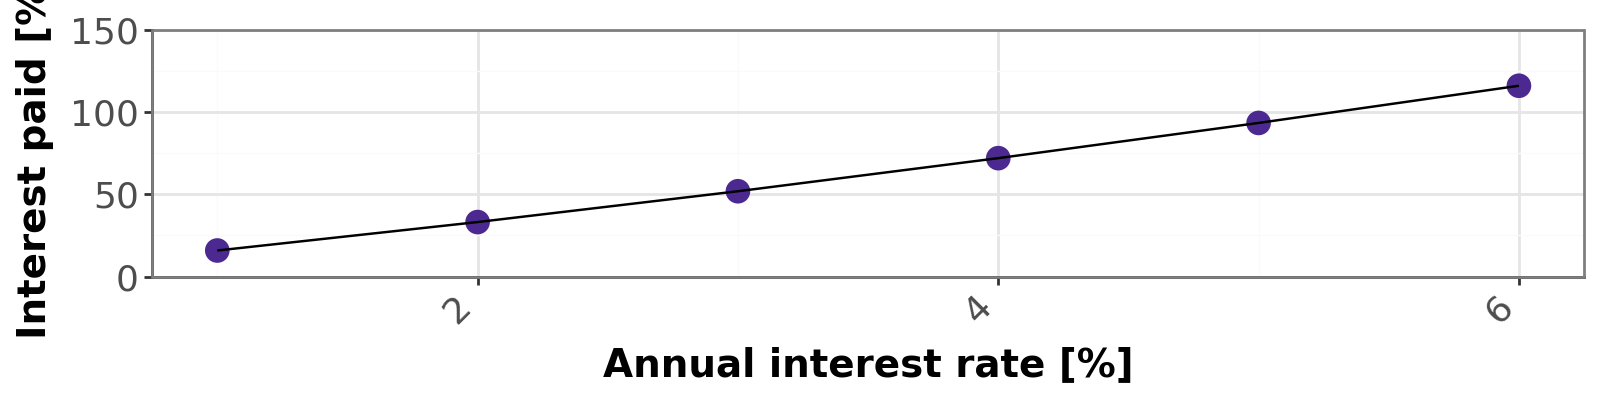

In [378]:
rlow = [0.01/12,0.02/12,0.03/12,0.04/12,0.05/12,0.06/12]
theCost = []
for i in range(len(rlow)):
    theCost.append(360 * 1 * (rlow[i]*(1+rlow[i])**360)/((1+rlow[i])**360-1))

df_plot = pd.DataFrame()
df_plot['Interest'] = [1200*i for i in rlow]
df_plot['AmountPaid'] = theCost
df_plot['AmountPaid'] = df_plot['AmountPaid'].subtract(1).multiply(100)

plot_base = ggplot(df_plot,aes(x='Interest',y='AmountPaid')) + geom_point(size=4,color=color_sunset_0) + geom_line()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 2)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Interest paid [%]',expand=[0,0],limits=[0,150]) +\
        scale_x_continuous(name = 'Annual interest rate [%]',limits=[1,6])

plot_clean



---



##  <font color='orange'> Retrofit Program </font>

In [379]:
# Retrofit program costs
retrofitted_blds = df_SF[df_SF['RetrofitFlag']==True].shape[0]
retrofitProgram_costs = 6000 * retrofitted_blds

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 2023 rows containing non-finite values.


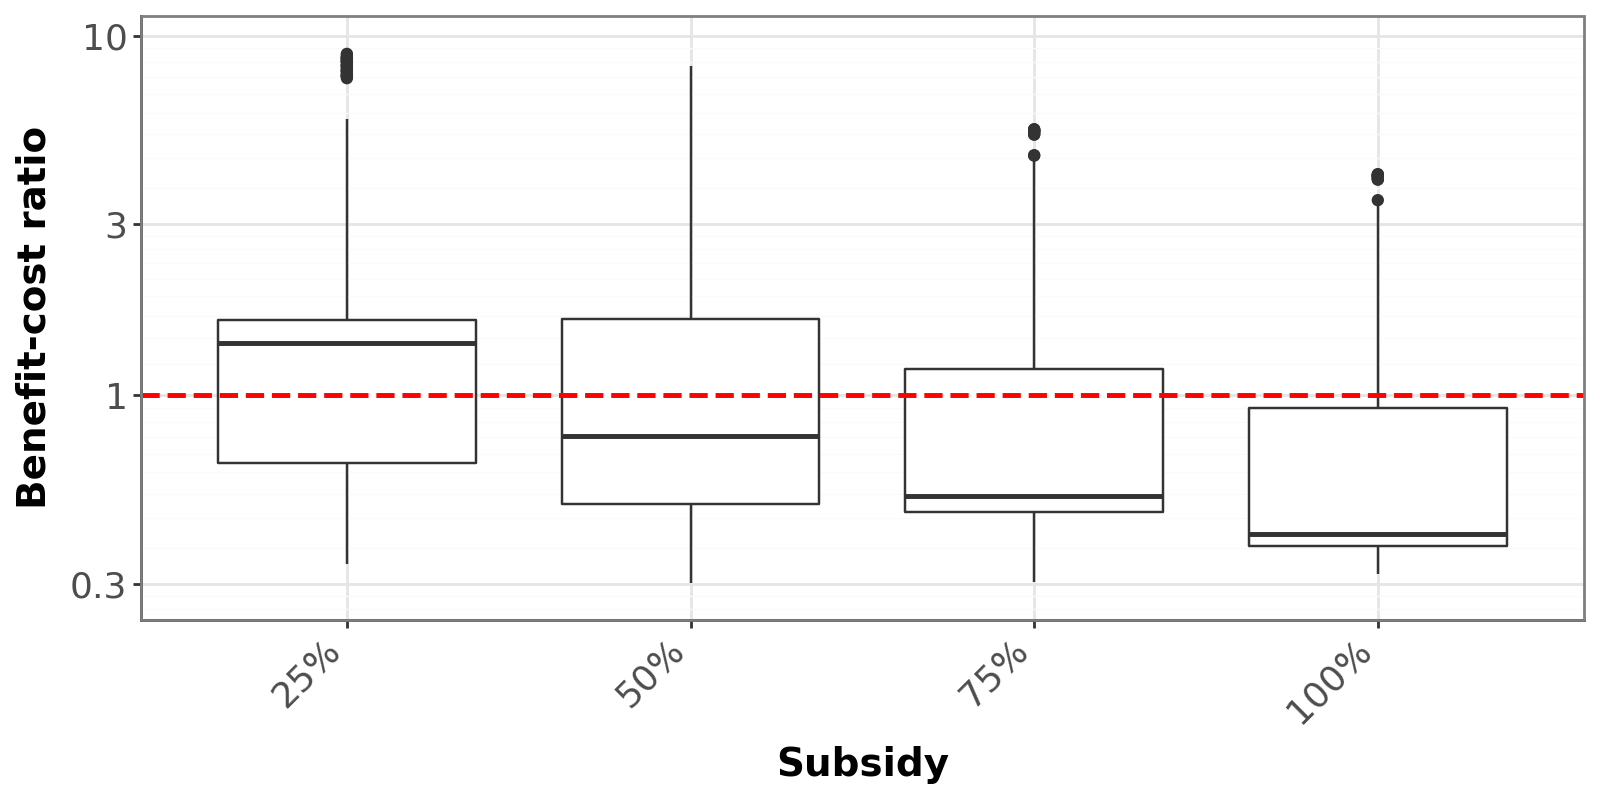

In [380]:
df_CBA_Retrofit = pd.DataFrame()

df_CBA_Retrofit['Losses'] = df_Scenario_costs['Losses'].divide(10**9)
df_CBA_Retrofit['25%'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit'])/(1500 * retrofitted_blds)
df_CBA_Retrofit['50%'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit'])/(3000 * retrofitted_blds)
df_CBA_Retrofit['75%'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit'])/(4500 * retrofitted_blds)
df_CBA_Retrofit['100%'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit'])/(6000 * retrofitted_blds)

df_CBA_Retrofit_long = pd.melt(df_CBA_Retrofit,id_vars='Losses')

df_CBA_Retrofit_long['variable'] = pd.Categorical(df_CBA_Retrofit_long['variable'] ,
                      categories=['25%','50%','75%','100%'],
                      ordered=True)

plot_base = ggplot(df_CBA_Retrofit_long,aes(x='variable',y='value')) +\
             geom_boxplot() + geom_hline(yintercept=1,size=1,linetype='dashed',color='red')

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.25,0.89),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8,4)) +\
        scale_color_manual(name = 'legend', values=[color_sunset_0,color_sunset_1]) +\
        scale_y_log10(name = 'Benefit-cost ratio',expand=[0,0.1],limits=[0.3,9]) +\
        scale_x_discrete(name = 'Subsidy')

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 340 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


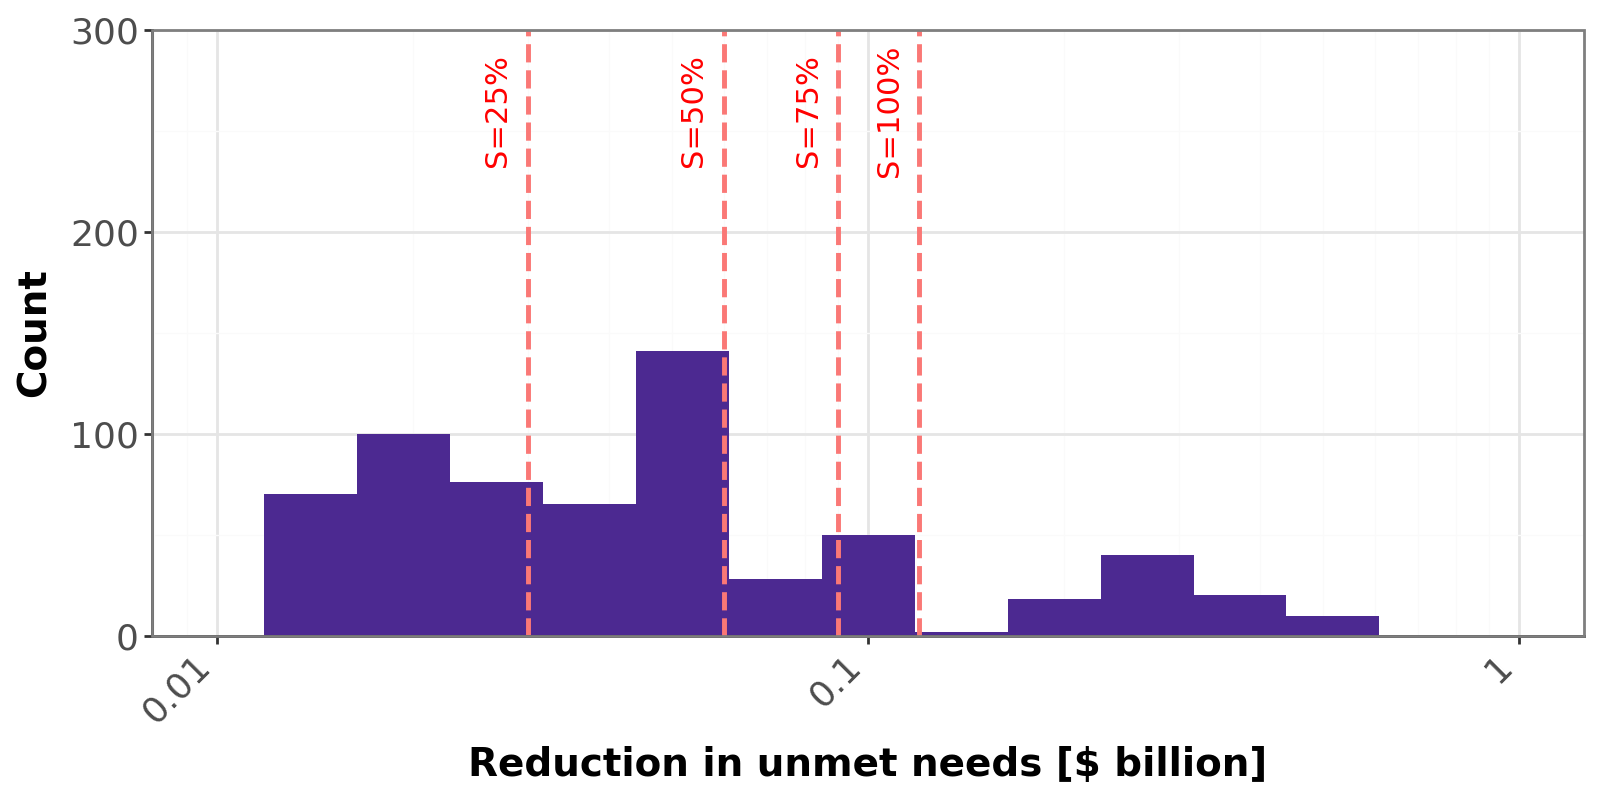

In [381]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Benefit')) + geom_histogram(bins=15,fill=color_sunset_0) +\
             geom_vline(color=color_sunset_2,xintercept=1500 * retrofitted_blds/10**9,size=1,linetype='dashed') + annotate('text', x=0.9*1500 * retrofitted_blds/10**9, y = 260, label='S=25%',color='red',angle=90)+\
             geom_vline(color=color_sunset_2,xintercept=3000 * retrofitted_blds/10**9,size=1,linetype='dashed') + annotate('text', x=0.9*3000 * retrofitted_blds/10**9, y = 260, label='S=50%',color='red',angle=90)+\
             geom_vline(color=color_sunset_2,xintercept=4500 * retrofitted_blds/10**9,size=1,linetype='dashed') + annotate('text', x=0.9*4500 * retrofitted_blds/10**9, y = 260, label='S=75%',color='red',angle=90)+\
             geom_vline(color=color_sunset_2,xintercept=6000 * retrofitted_blds/10**9,size=1,linetype='dashed') + annotate('text', x=0.9*6000 * retrofitted_blds/10**9, y = 260, label='S=100%',color='red',angle=90)


plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,300]) +\
        scale_x_log10(name = 'Reduction in unmet needs [$ billion]',expand=[0,0.1],limits=[0.01,1])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 340 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


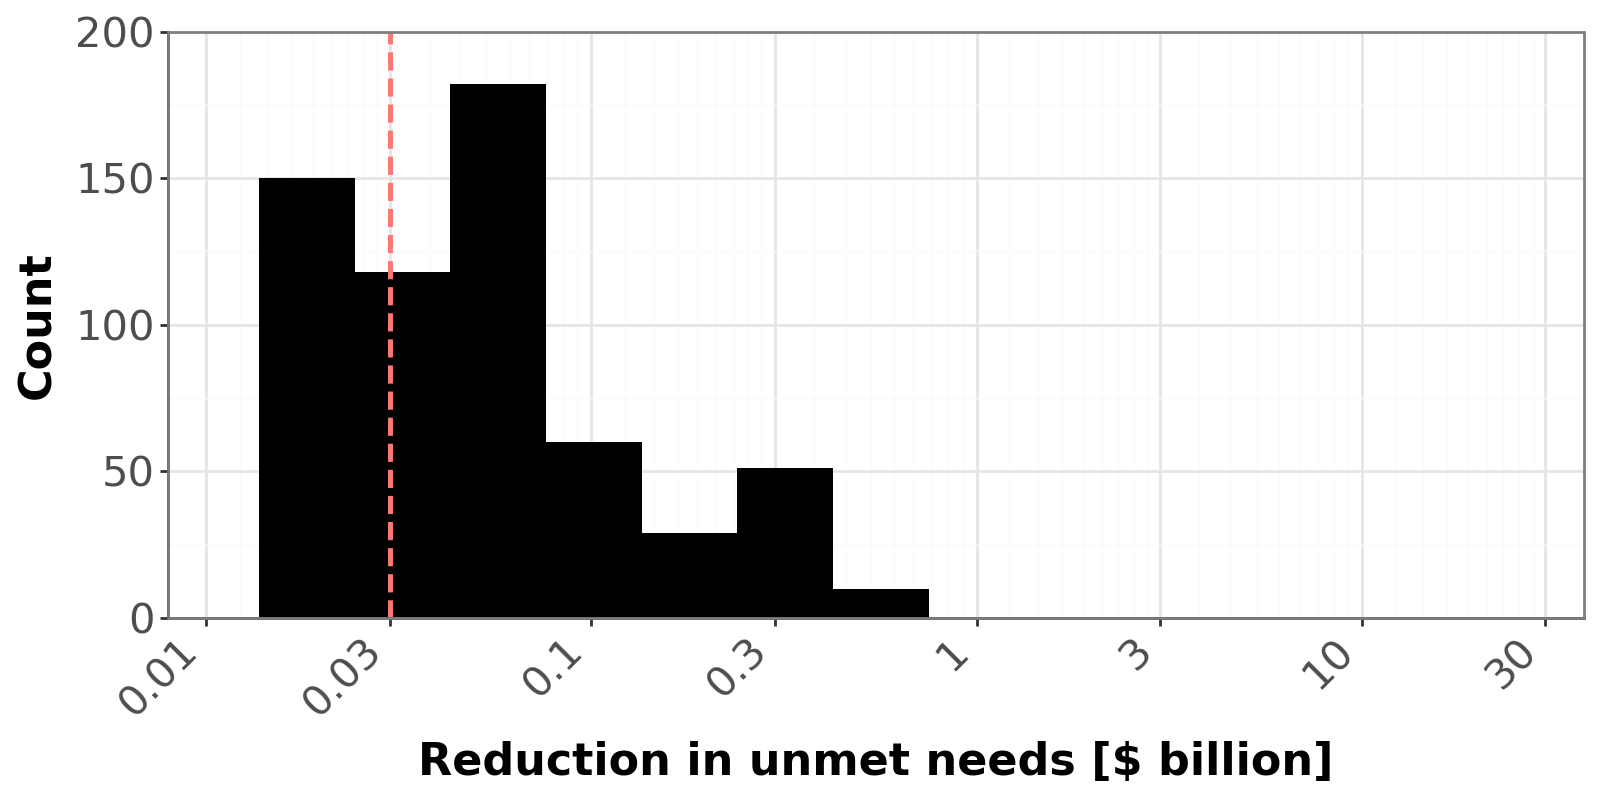

In [438]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Expenditure'] = [3000 * retrofitted_blds] * df_plot.shape[0]
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Benefit')) + geom_histogram(bins=15,fill='black') + geom_vline(color=color_sunset_2,xintercept=1500 * retrofitted_blds/10**9,size=1,linetype='dashed')

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Reduction in unmet needs [$ billion]',expand=[0,0.1],limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


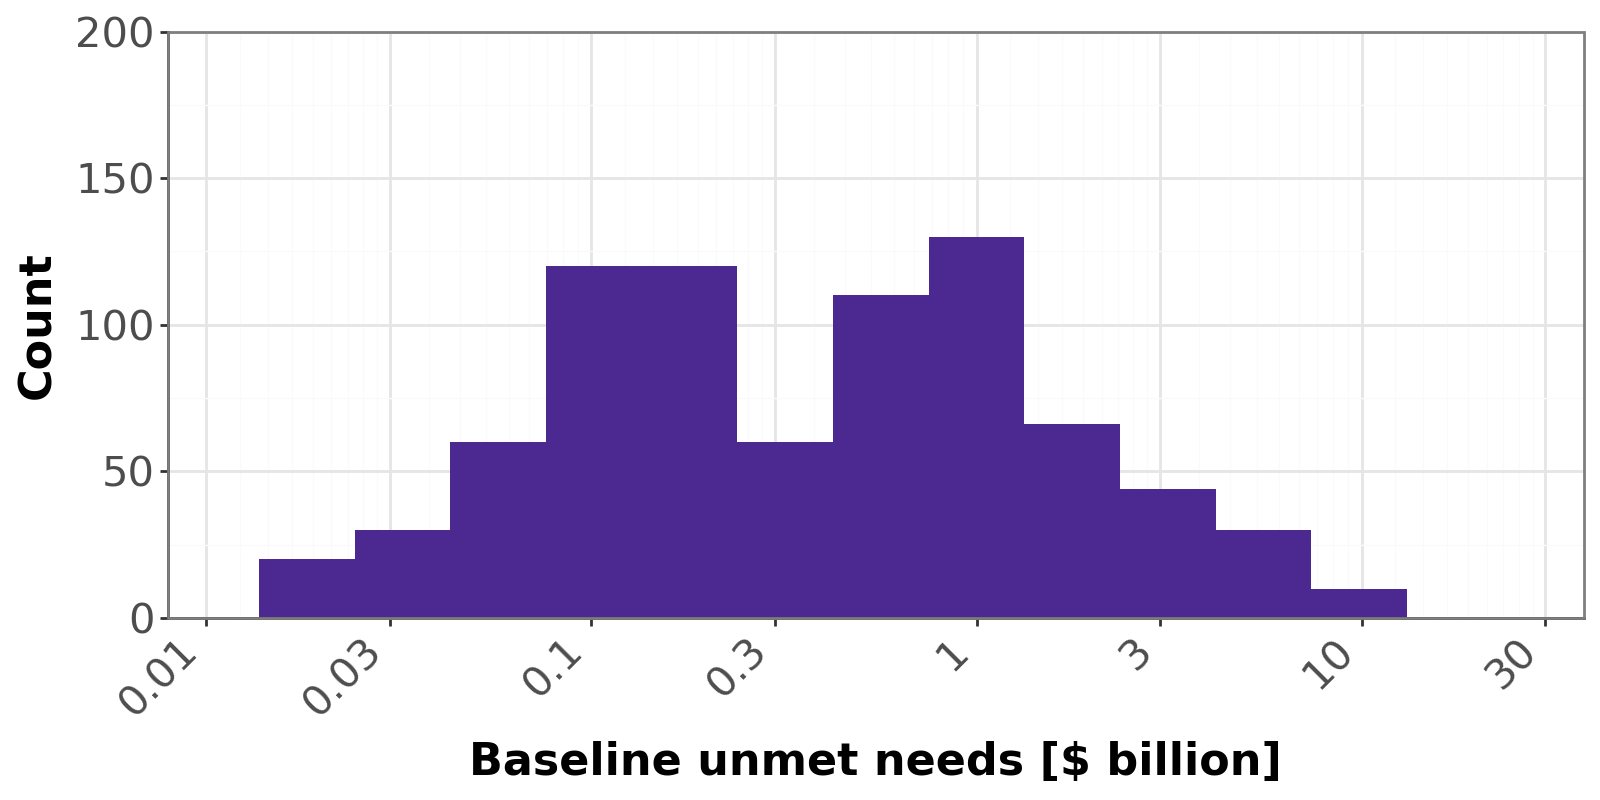

In [436]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Expenditure'] = [1500 * retrofitted_blds] * df_plot.shape[0]
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['Retrofit']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Baseline')) + geom_histogram(bins=15,fill=color_sunset_0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Baseline unmet needs [$ billion]',expand=[0,0.1],limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean



---



##  <font color='orange'> EQC-like Insurance Program </font>

In [505]:
df_CBA_Insurance = pd.DataFrame()
#theYearlyPremiums = np.sum([np.minimum(df_SF.loc[i,'ReplacementCost'],300000) * 0.16/100 for i in range(df_SF.shape[0])])

p = list(range(10,110,10))
#p = [i/100 for i in p]
v = []

for j in p:
  #v.append(np.sum([np.minimum(df_SF.loc[i,'ReplacementCost'],300000) * j/(100*100) for i in range(df_SF.shape[0])]))
  v.append(df_SF.shape[0] * 300000 * j/(100*100))

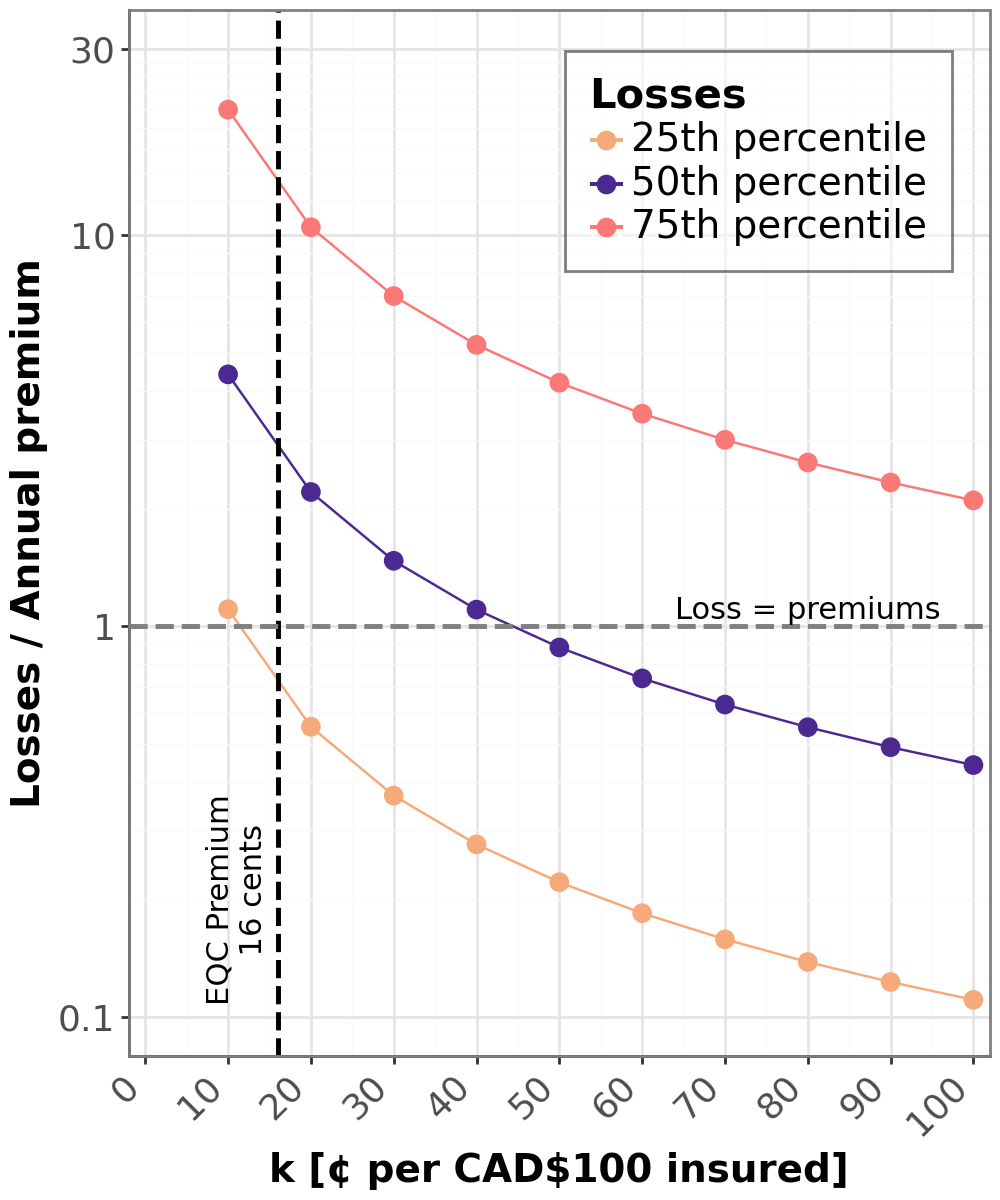

In [506]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Losses'] = df_Scenario_costs['Losses']
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC'])
df_CBA_Insurance['AAL'] = df_CBA_Insurance['Losses']#.apply(lambda x: (1 - np.exp(-(1/1501)*1))*x)

u25 = []
u50 = []
u75 = []
for i in range(len(v)):
  # u.append(df_CBA_Insurance[df_CBA_Insurance['AAL']>v[i]].shape[0]/df_CBA_Insurance.shape[0])
  #u.append(df_CBA_Insurance['AAL'].median()/v[i])
  u25.append(np.percentile(df_CBA_Insurance['AAL'],25)/v[i])
  u50.append(np.percentile(df_CBA_Insurance['AAL'],50)/v[i])
  u75.append(np.percentile(df_CBA_Insurance['AAL'],75)/v[i])


df_plot = pd.DataFrame()
df_plot['Premiums'] = p
df_plot['25th percentile'] = u25
df_plot['50th percentile'] = u50
df_plot['75th percentile'] = u75
df_plot_long = pd.melt(df_plot,id_vars='Premiums')

plot_base = ggplot(df_plot_long,aes(x='Premiums',y='value', color='variable')) + geom_point(size=3) +\
             geom_line(size=0.5) +\
             geom_vline(xintercept=16,linetype='dashed',size=1,color='black') +\
             geom_hline(yintercept=1,linetype='dashed',size=1,color='gray') +\
             annotate('text', x=11, y = 0.2, label='EQC Premium\n  16 cents',color='black',angle=90) +\
             annotate('text', x=80, y = 1.1, label='Loss = premiums',color='black',angle=0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.92,0.95),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        scale_color_manual(name ='Losses',values=[color_sunset_1,color_sunset_0,color_sunset_2])+\
        theme(figure_size=(5, 6)) +\
        scale_y_log10(name = 'Losses / Annual premium',expand=[0,0.1],limits=[0.1,30],breaks=[0.1,1,10,30]) +\
        scale_x_continuous(name = 'k [\xa2 per CAD$100 insured]',expand=[0,2],limits=[0,100],breaks=list(range(0,110,10)))

plot_clean

In [509]:
np.percentile(df_CBA_Insurance['AAL'],75)

935122986.0810909

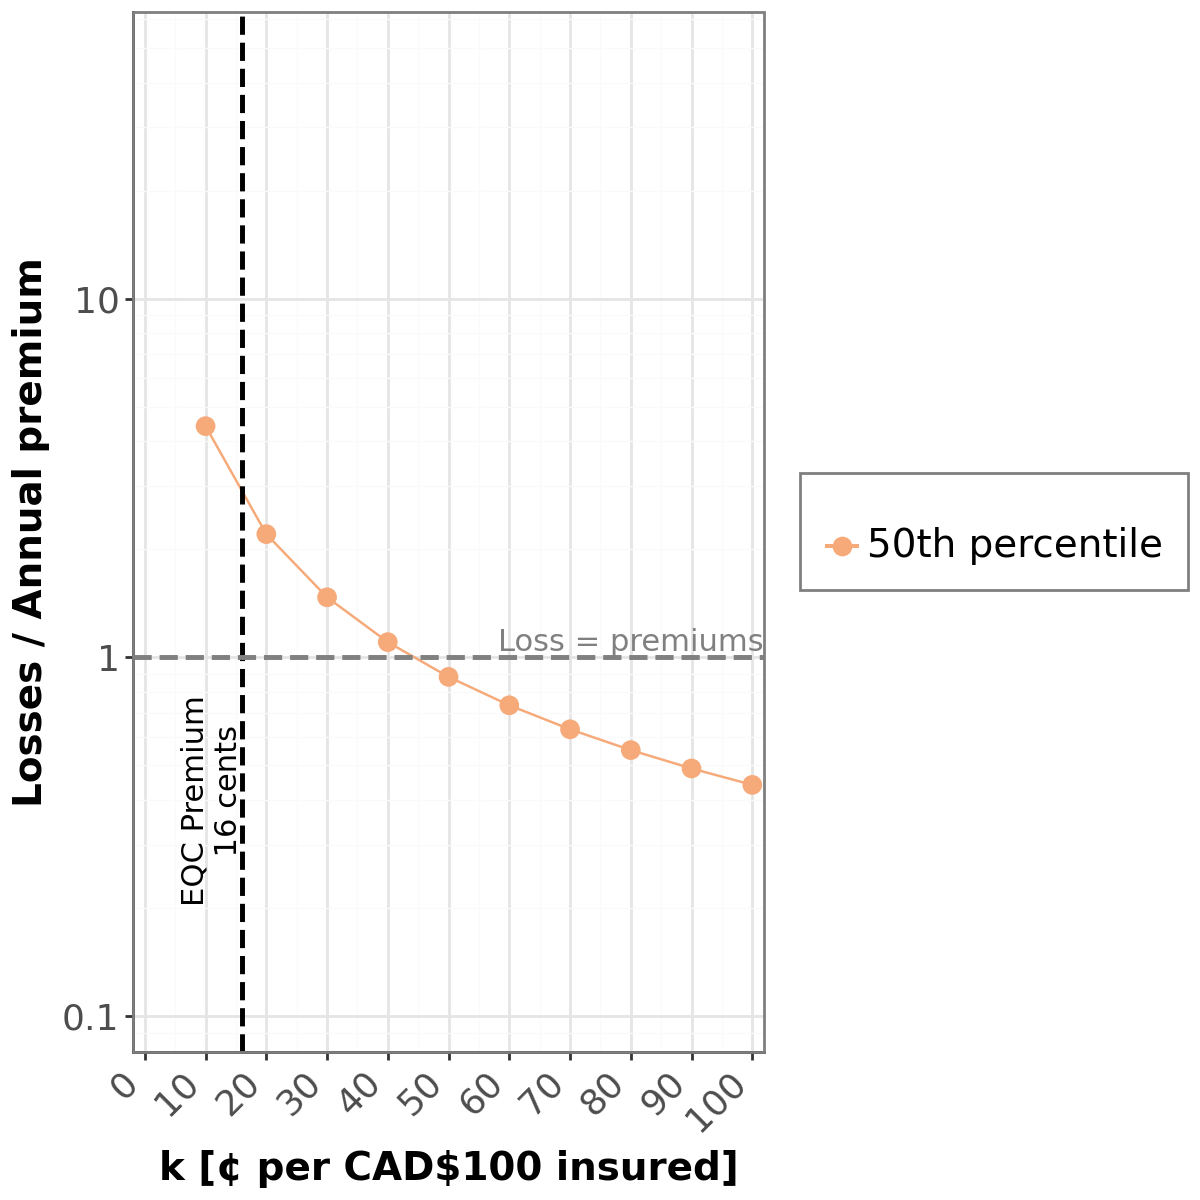

In [386]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Losses'] = df_Scenario_costs['Losses']
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC'])
df_CBA_Insurance['AAL'] = df_CBA_Insurance['Losses']#.apply(lambda x: (1 - np.exp(-(1/1501)*1))*x)

u25 = []
u50 = []
u75 = []
for i in range(len(v)):
  # u.append(df_CBA_Insurance[df_CBA_Insurance['AAL']>v[i]].shape[0]/df_CBA_Insurance.shape[0])
  #u.append(df_CBA_Insurance['AAL'].median()/v[i])
  u25.append(np.percentile(df_CBA_Insurance['AAL'],25)/v[i])
  u50.append(np.percentile(df_CBA_Insurance['AAL'],50)/v[i])
  u75.append(np.percentile(df_CBA_Insurance['AAL'],75)/v[i])


df_plot = pd.DataFrame()
df_plot['Premiums'] = p
df_plot['50th percentile'] = u50
df_plot_long = pd.melt(df_plot,id_vars='Premiums')

plot_base = ggplot(df_plot_long,aes(x='Premiums',y='value', color='variable')) + geom_point(size=3) +\
             geom_line(size=0.5) +\
             geom_vline(xintercept=16,linetype='dashed',size=1,color='black') +\
             geom_hline(yintercept=1,linetype='dashed',size=1,color='gray') +\
             annotate('text', x=11, y = 0.4, label='EQC Premium\n  16 cents',color='black',angle=90) +\
             annotate('text', x=80, y = 1.1, label='Loss = premiums',color='gray',angle=0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        scale_color_manual(name ='Losses',values=[color_sunset_1,color_sunset_0,color_sunset_2])+\
        theme(figure_size=(6, 6)) +\
        scale_y_log10(name = 'Losses / Annual premium',expand=[0,0.1],limits=[0.1,50]) +\
        scale_x_continuous(name = 'k [\xa2 per CAD$100 insured]',expand=[0,2],limits=[0,100],breaks=list(range(0,110,10)))

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


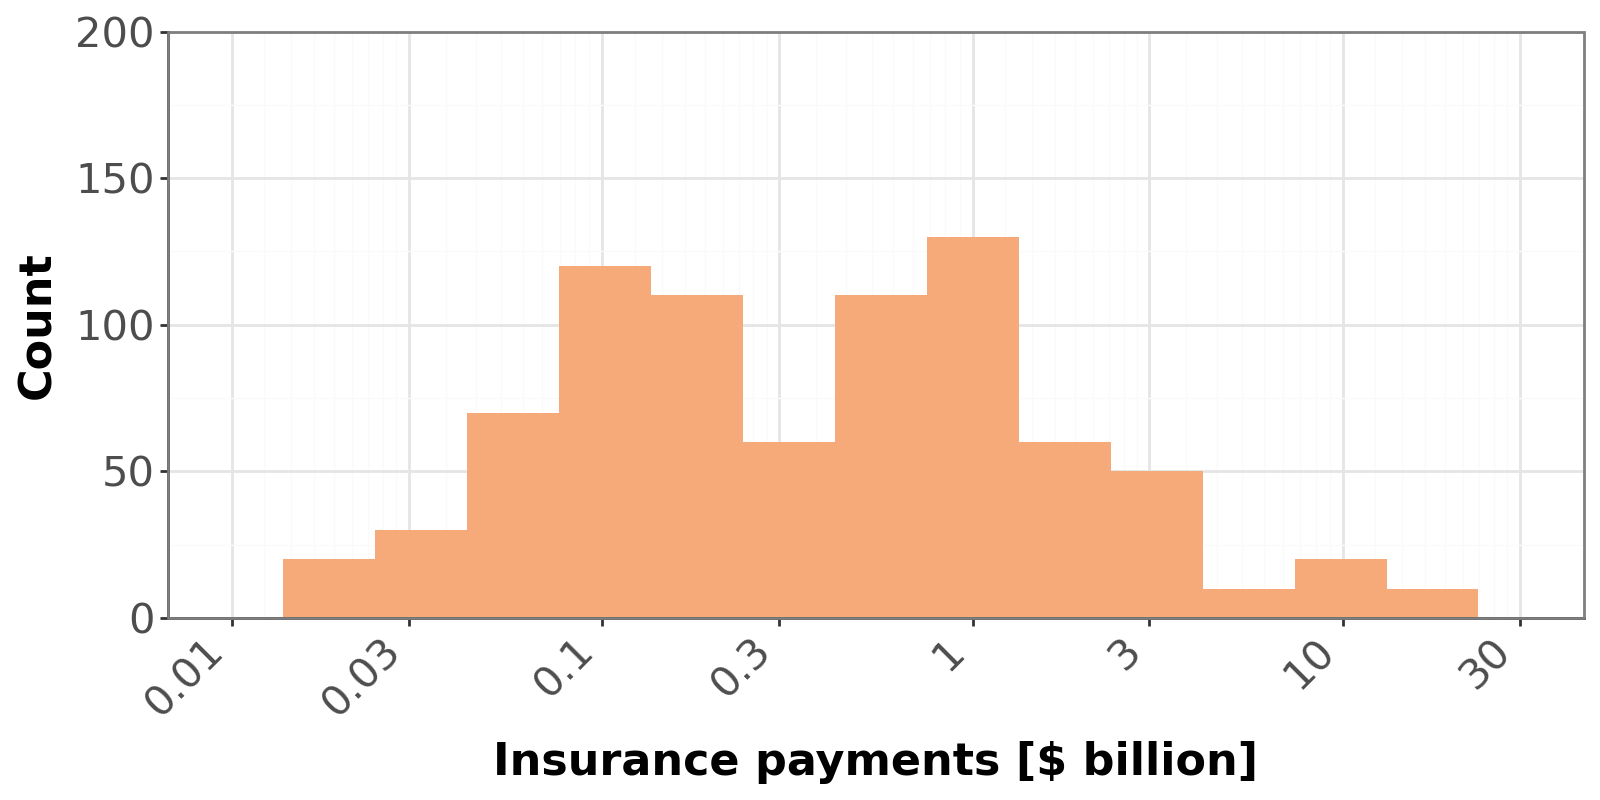

In [435]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Cost'] = df_Scenario_costs['EQC'].divide(10**9)
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC']).divide(10**9)

plot_base = ggplot(df_CBA_Insurance,aes(x='Cost')) + geom_histogram(bins=15,fill=color_sunset_1)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Insurance payments [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


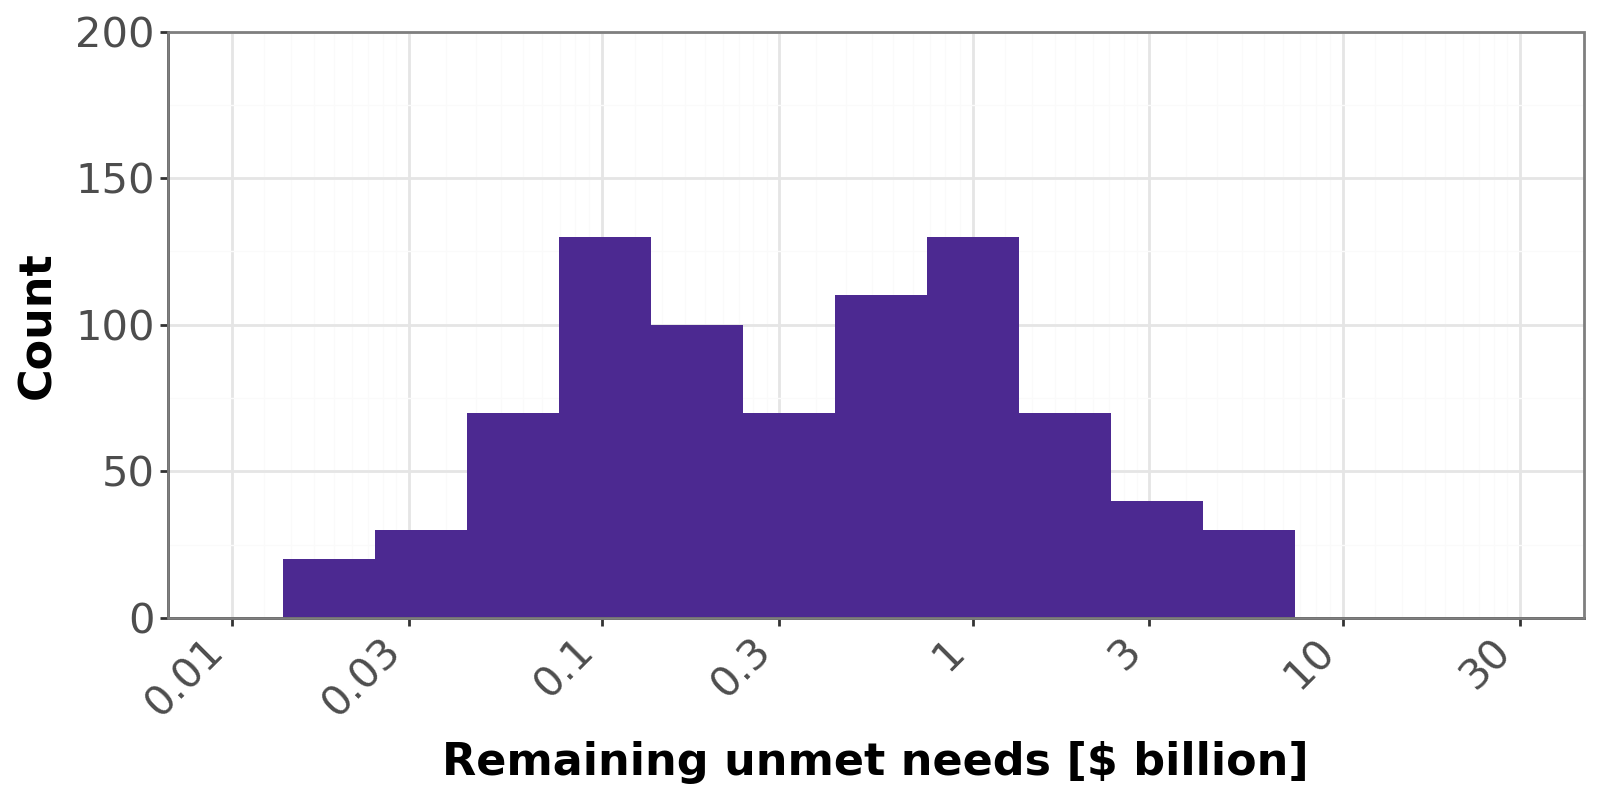

In [434]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Cost'] = df_Scenario_costs['EQC'].divide(10**9)
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC']).divide(10**9)

plot_base = ggplot(df_CBA_Insurance,aes(x='Benefit')) + geom_histogram(bins=15,fill=color_sunset_0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Remaining unmet needs [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 3 rows containing missing values.


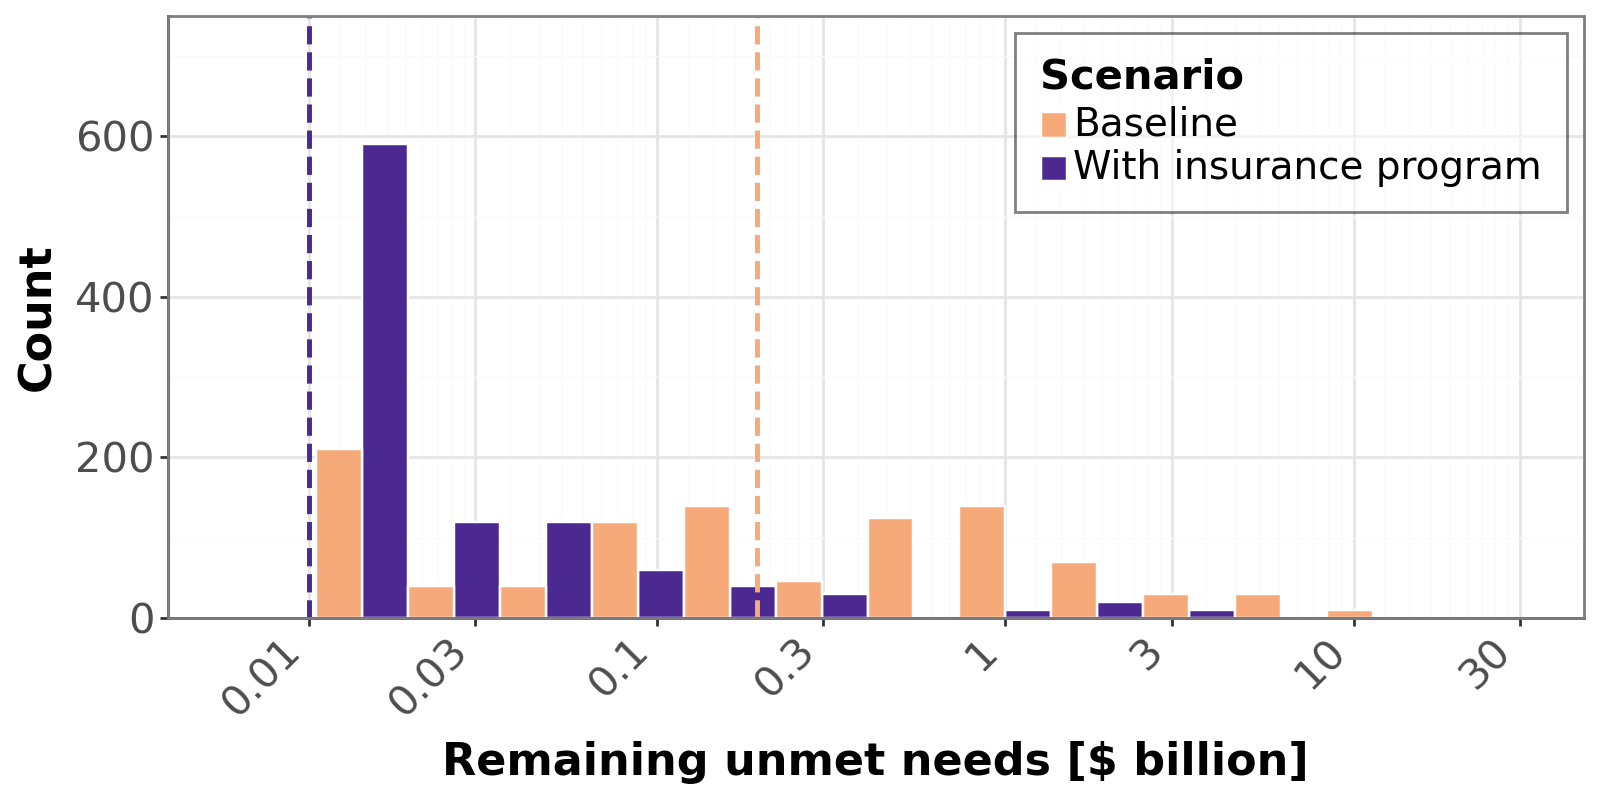

In [499]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline'].divide(10**9)
df_plot['With insurance program'] = df_Scenario_UHN['EQC'].divide(10**9)

df_plot_long = pd.melt(df_plot)
df_plot_long['value'] = df_plot_long['value'].apply(lambda x: 0.011 if x < 0.01 else x)

plot_base = ggplot(df_plot_long,aes(x='value',fill='variable'))\
           + geom_histogram(bins=15,position='dodge',alpha=1,color='white')\
           + geom_vline(xintercept=df_plot['Baseline'].median(),linetype='dashed',color=color_sunset_1,size=1)\
           + geom_vline(xintercept=0.01,linetype='dashed',color=color_sunset_0,size=1)


plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.98,0.96),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_fill_manual(name = 'Scenario', values=[color_sunset_1,color_sunset_0]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,750]) +\
        scale_x_log10(name = 'Remaining unmet needs [$ billion]',limits=[0.006,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

In [500]:
print(df_plot['Baseline'].median())
print(df_plot['With insurance program'].median())

0.1931129691415724
0.006670101829189723


/opt/anaconda3/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 92'. Pick better value with 'binwidth'.


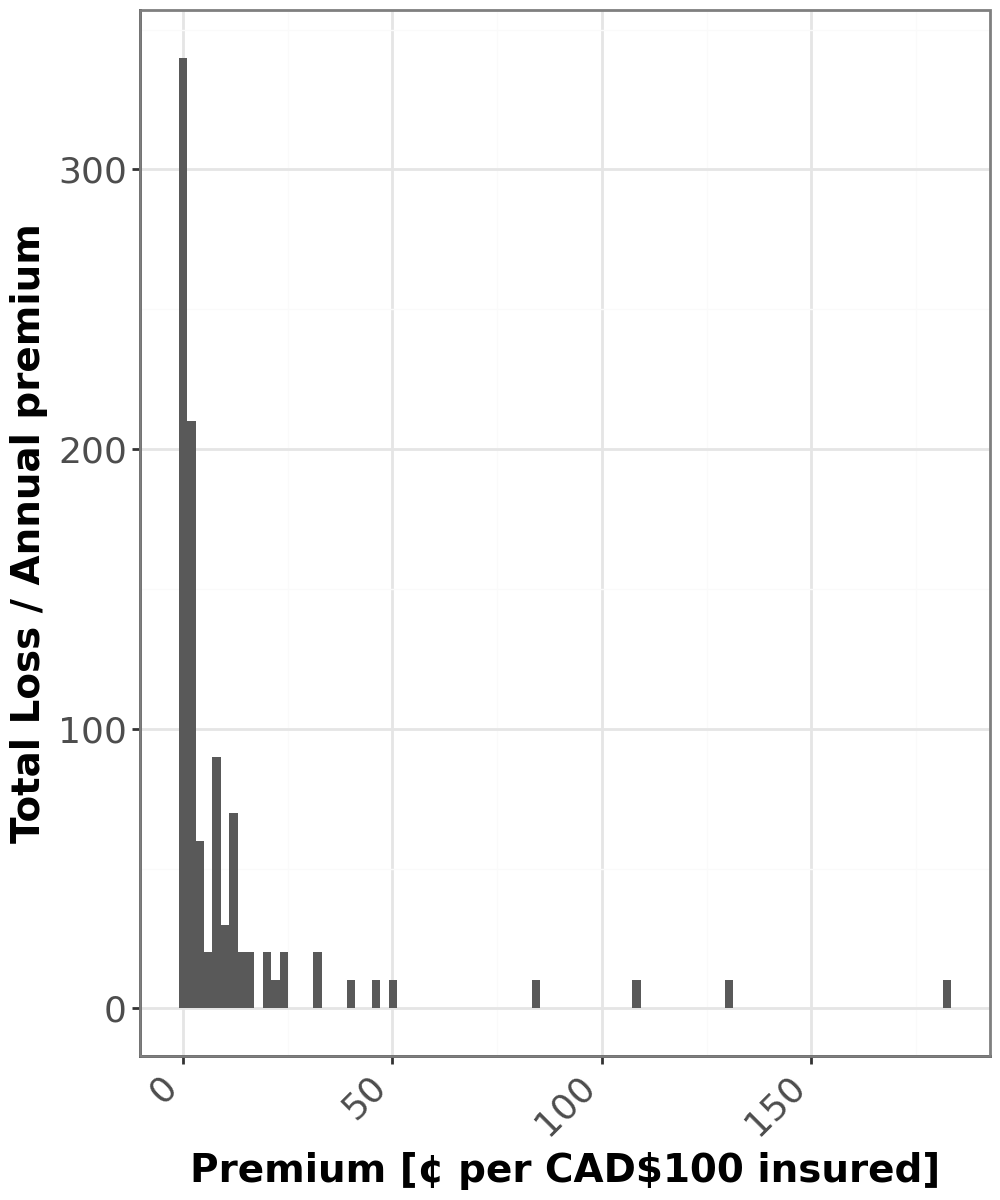

In [390]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Losses'] = df_Scenario_costs['Losses']
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC'])
df_CBA_Insurance['Hist'] = df_CBA_Insurance['Losses'].divide(v[1])

plot_base = ggplot(df_CBA_Insurance,aes(x='Hist')) + geom_histogram()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.75,0.23),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 6)) +\
        scale_y_continuous(name = 'Total Loss / Annual premium') +\
        scale_x_continuous(name = 'Premium [\xa2 per CAD$100 insured]')

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


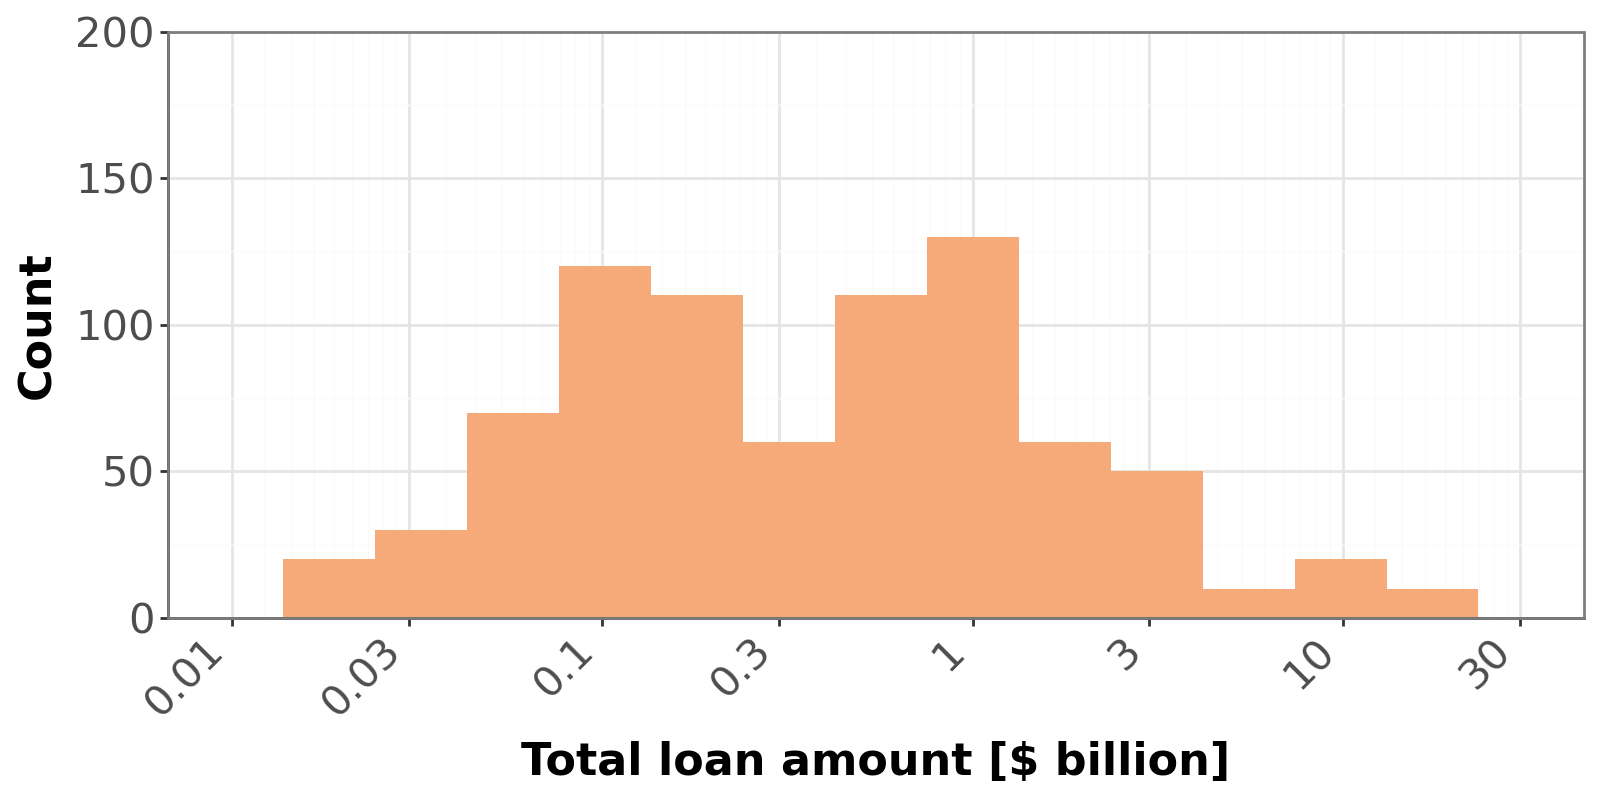

In [432]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Expenditure'] = df_Scenario_costs['EQC']
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_costs['EQC']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Expenditure')) + geom_histogram(bins=15,fill=color_sunset_1)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Total loan amount [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

/Users/rcosta/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 180 rows containing non-finite values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


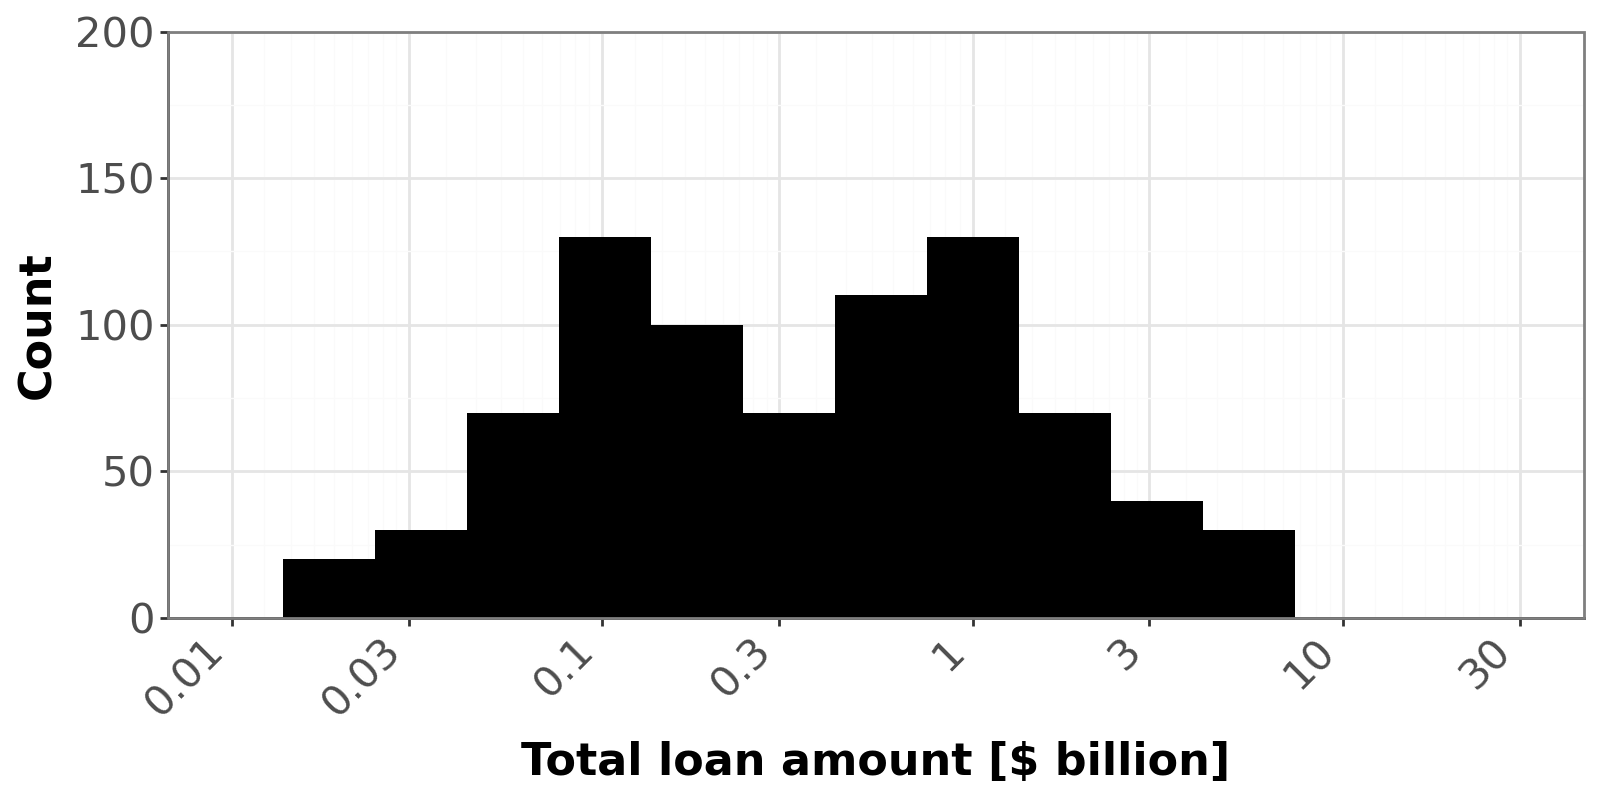

In [431]:
df_plot = pd.DataFrame()
df_plot['Baseline'] = df_Scenario_UHN['Baseline']
df_plot['Expenditure'] = df_Scenario_costs['EQC']
df_plot['Benefit'] = df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC']
df_plot = df_plot.divide(10**9)

plot_base = ggplot(df_plot,aes(x='Benefit')) + geom_histogram(bins=15,fill='black')

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=15),
        axis_title=element_text(size=16,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.86,0.88),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(8, 4)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1]) +\
        scale_y_continuous(name = 'Count',expand=[0,0],limits=[0,200]) +\
        scale_x_log10(name = 'Total loan amount [$ billion]',limits=[0.01,30],breaks=[0.01,0.03,0.1,0.3,1,3,10,30])

plot_clean

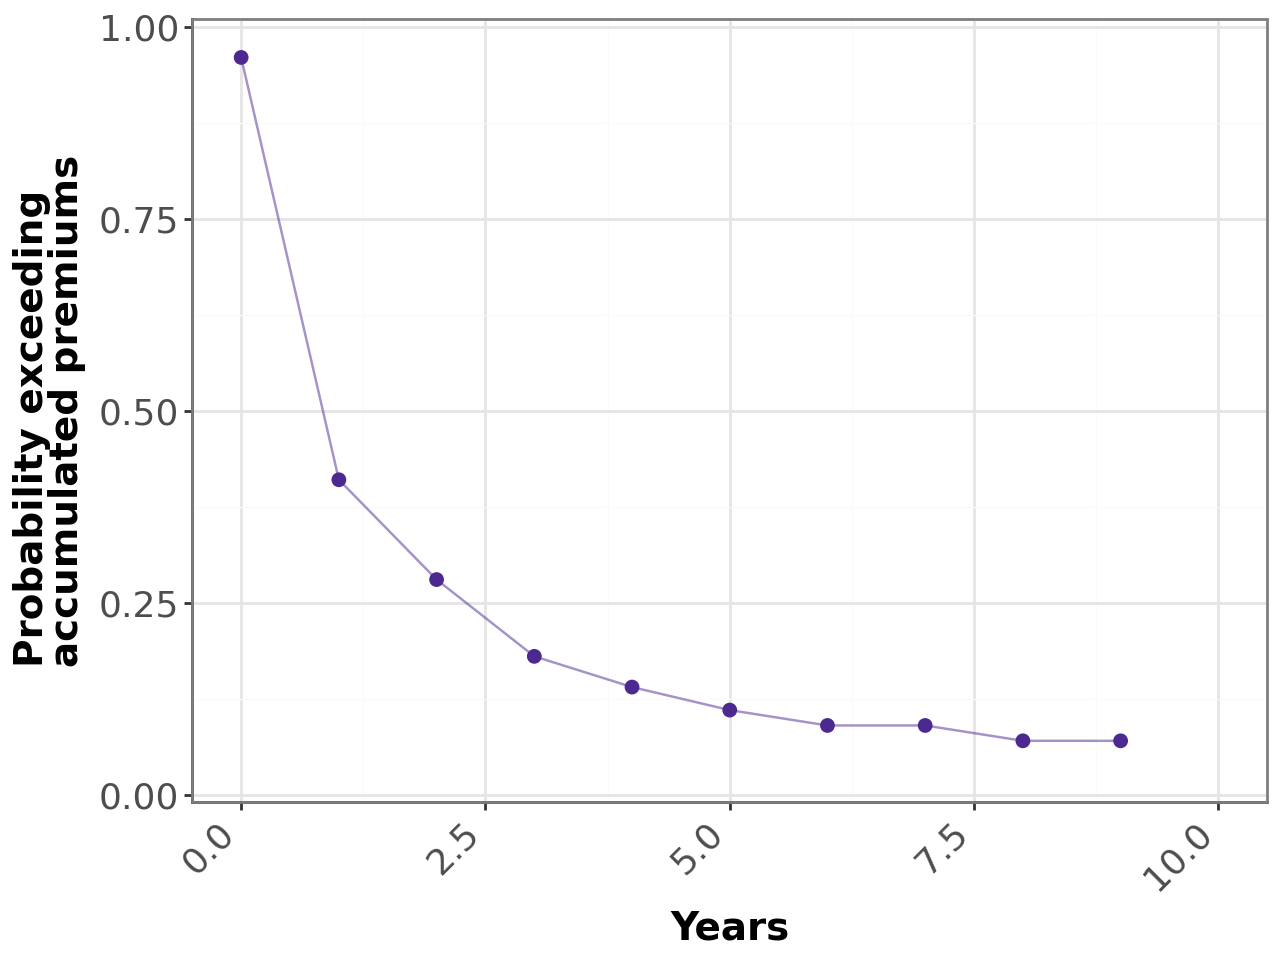

In [393]:
df_CBA_Insurance = pd.DataFrame()
df_CBA_Insurance['Losses'] = df_Scenario_costs['Losses']
df_CBA_Insurance['Benefit'] = (df_Scenario_UHN['Baseline'] - df_Scenario_UHN['EQC'])
df_CBA_Insurance['Years'] = df_CBA_Insurance['Losses'].apply(lambda x: x / 399368160.0)

y = list(range(10))
u = []
for i in range(len(y)):
  u.append(df_CBA_Insurance[df_CBA_Insurance['Years']>y[i]].shape[0]/df_CBA_Insurance.shape[0])

df_plot = pd.DataFrame()
df_plot['Years'] = y
df_plot['ProbEx'] = u

plot_base = ggplot(df_plot,aes(x='Years',y='ProbEx')) +\
 geom_point(color=color_sunset_0,size=2) +\
 geom_line(color=color_sunset_0,size=0.5,alpha=0.5)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.75,0.23),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        scale_y_continuous(name = 'Probability exceeding\naccumulated premiums',expand=[0,0.01],limits=[0,1]) +\
        scale_x_continuous(name = 'Years',limits=[0,10],expand=[0,0.5])

plot_clean



---



---



##  <font color='orange'> Homeowner </font>

In [394]:
homevalue = 500000
r = 8/1200
theDMGRatios = list(range(5,105,5))
theDMGRatios = [i/100 for i in theDMGRatios]
theLosses = [homevalue*i for i in theDMGRatios]
theInsuredAmount = [np.minimum((theDMGRatios[i]-theInsuranceDeductible)*homevalue,(1-theInsuranceDeductible)*homevalue) if theDMGRatios[i] > theInsuranceDeductible else 0 for i in range(len(theLosses))]

df_Today = pd.DataFrame()
df_Today['Loss'] = theLosses
df_Today['InsuredLosses'] = theInsuredAmount
df_Today['Unmet'] = df_Today['Loss'] - df_Today['InsuredLosses']
df_Today['DebtWithoutInsurance'] = df_Today['Loss'].apply(lambda x: 360*x*(r*(r+1)**360)/((1+r)**360-1))
df_Today['DebtWithInsurance'] = df_Today['Unmet'].apply(lambda x: 360*x*(r*(r+1)**360)/((1+r)**360-1))
df_Today

,Loss,InsuredLosses,Unmet,DebtWithoutInsurance,DebtWithInsurance
0,25000.0,0.0,25000.0,6.603881e+04,66038.811649
1,50000.0,0.0,50000.0,1.320776e+05,132077.623298
2,75000.0,12500.0,62500.0,1.981164e+05,165097.029123
3,100000.0,37500.0,62500.0,2.641552e+05,165097.029123
4,125000.0,62500.0,62500.0,3.301941e+05,165097.029123
5,150000.0,87500.0,62500.0,3.962329e+05,165097.029123
6,175000.0,112500.0,62500.0,4.622717e+05,165097.029123
7,200000.0,137500.0,62500.0,5.283105e+05,165097.029123
8,225000.0,162500.0,62500.0,5.943493e+05,165097.029123
9,250000.0,187500.0,62500.0,6.603881e+05,165097.029123


In [395]:
r2 = 4/1200
theEQC = [np.minimum(0.99*(np.minimum(i,300000)),i-200) for i in theLosses]

df_Improved = pd.DataFrame()
df_Improved['Loss'] = theLosses
df_Improved['EQC'] = theEQC
df_Improved['LoanEligible'] = df_Improved['Loss'] - df_Improved['EQC']
df_Improved['LoanAmount'] = df_Improved['LoanEligible'].apply(lambda x: np.maximum((0.4692*x-1891),0))
df_Improved['Unmet'] = df_Improved['Loss'] - df_Improved['EQC'] - df_Improved['LoanAmount']
df_Improved['Debt'] =  df_Improved['Unmet'].apply(lambda x: 360*x*(r*(r+1)**360)/((1+r)**360-1)) +\
                                df_Improved['LoanAmount'].apply(lambda x: 360*x*(r2*(r2+1)**360)/((1+r2)**360-1))
df_Improved

,Loss,EQC,LoanEligible,LoanAmount,Unmet,Debt
0,25000.0,24750.0,250.0,0.0,250.0,660.388116
1,50000.0,49500.0,500.0,0.0,500.0,1320.776233
2,75000.0,74250.0,750.0,0.0,750.0,1981.164349
3,100000.0,99000.0,1000.0,0.0,1000.0,2641.552466
4,125000.0,123750.0,1250.0,0.0,1250.0,3301.940582
5,150000.0,148500.0,1500.0,0.0,1500.0,3962.328699
6,175000.0,173250.0,1750.0,0.0,1750.0,4622.716815
7,200000.0,198000.0,2000.0,0.0,2000.0,5283.104932
8,225000.0,222750.0,2250.0,0.0,2250.0,5943.493048
9,250000.0,247500.0,2500.0,0.0,2500.0,6603.881165


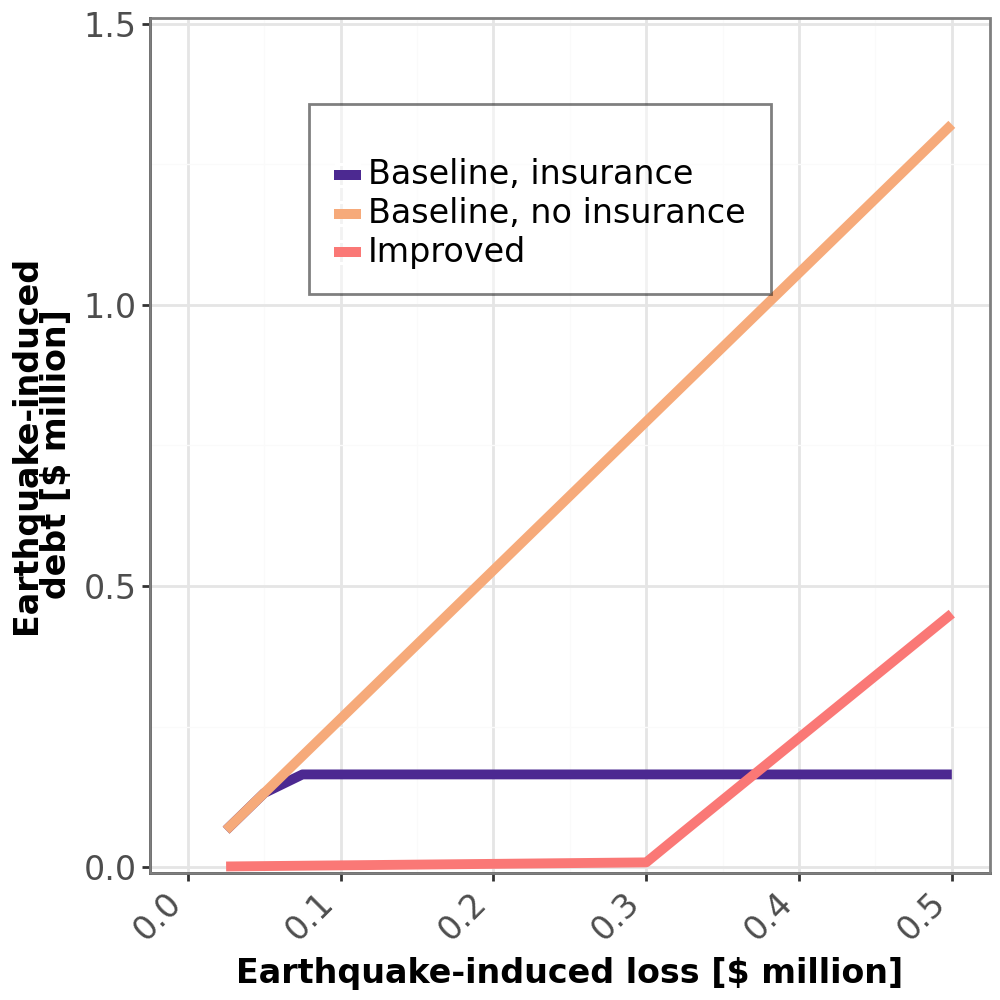

In [396]:
df_plot = pd.DataFrame()
df_plot['Loss'] = theLosses
df_plot['Baseline, no insurance'] = df_Today['DebtWithoutInsurance']
df_plot['Baseline, insurance'] = df_Today['DebtWithInsurance']
df_plot['Improved'] = df_Improved['Debt'].add(800)
df_plot = df_plot.divide(10**6)

df_plot_long = pd.melt(df_plot,id_vars='Loss')

plot_base = ggplot(df_plot_long,aes(x='Loss',y='value',color='variable')) + geom_line(size=2)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=12),
        axis_title=element_text(size=12,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.42,0.87),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 5)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1,color_sunset_2])+\
        scale_y_continuous(name = 'Earthquake-induced\n   debt [$ million]',expand=[0,0.01],limits=[0,1.5]) +\
        scale_x_continuous(name = 'Earthquake-induced loss [$ million]',limits=[0,0.5])

plot_clean

/opt/anaconda3/lib/python3.11/site-packages/plotnine/stats/smoothers.py:338: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/opt/anaconda3/lib/python3.11/site-packages/plotnine/guides/guides.py:190: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


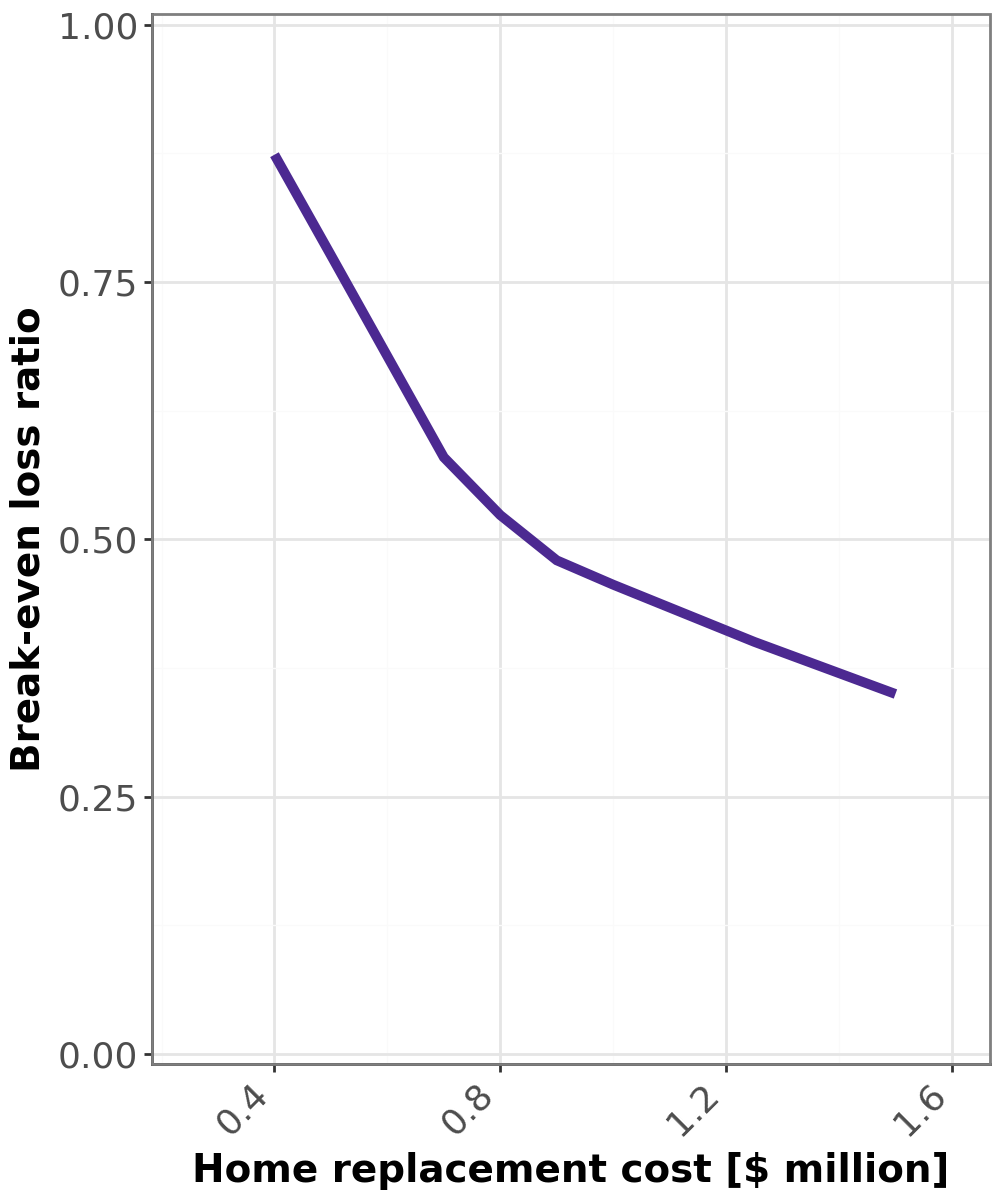

In [397]:
df_plot = pd.DataFrame()
df_plot['Home value'] = [0.4,0.5,0.7,0.8,0.9,1,1.25,1.5]
df_plot['Break even point'] = [0.9,0.75,0.56,0.51,0.47,0.45,0.4,0.35]

plot_base = ggplot(df_plot,aes(x='Home value',y='Break even point')) + geom_smooth(color=color_sunset_0,size=2)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=14,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.37,0.83),
        legend_box_margin=8,
        legend_title=element_blank(),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=14),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        theme(figure_size=(5, 6)) +\
        scale_color_manual(values=[color_sunset_0,color_sunset_1,color_sunset_2])+\
        scale_y_continuous(name = 'Break-even loss ratio',expand=[0,0.01],limits=[0,1]) +\
        scale_x_continuous(name = 'Home replacement cost [$ million]',limits=[0.25,1.6])

plot_clean



---



---



In [398]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)



---



---



# Improvements

###  <font color='orange'> Loss </font>

In [ ]:
df_Scenarios = pd.DataFrame()
df_Scenarios['Baseline'] = uhn_Baseline.mean()# / 10**6
df_Scenarios['Parametric'] = uhn_Parametric.mean()# / 10**6
df_Scenarios['Loans'] = uhn_Loans.mean()# / 10**6
df_Scenarios['Baseline_r1'] = uhn_Baseline_r1.mean()# / 10**6

df_Scenarios = df_Scenarios.reset_index(drop=True)

df_Scenarios_long = pd.melt(df_Scenarios)
df_Scenarios_long['variable'] = pd.Categorical(df_Scenarios_long['variable'] ,
                      categories=['Baseline','Baseline_r1','Parametric','Loans'],
                      ordered=True)

plot_base = ggplot(df_Scenarios_long,aes(x='variable',y='value',fill='variable')) + geom_boxplot()
plot_base

###  <font color='orange'> Debt </font>

In [ ]:
df_Scenarios = pd.DataFrame()
df_Scenarios['Baseline'] = debt_Baseline.mean()# / 10**6
df_Scenarios['Parametric'] = debt_Parametric.mean()# / 10**6
df_Scenarios['Loans'] = debt_Loans.mean()# / 10**6
df_Scenarios['Baseline_r1'] = debt_Baseline_r1.mean()# / 10**6

df_Scenarios = df_Scenarios.reset_index(drop=True)

df_Scenarios_long = pd.melt(df_Scenarios)
df_Scenarios_long['variable'] = pd.Categorical(df_Scenarios_long['variable'] ,
                      categories=['Baseline','Baseline_r1','Parametric','Loans'],
                      ordered=True)

plot_base = ggplot(df_Scenarios_long,aes(x='variable',y='value',fill='variable')) + geom_boxplot()
plot_base

###  <font color='orange'> DFAA values - exceedance probability </font>

In [ ]:
df_Scenarios#.to_csv(main_dir + 'Scenarios_100.txt',index=False)
df_SF#    .to_csv(main_dir + 'df_SF.txt',index=False)

In [ ]:
df_DFAA = pd.DataFrame()
baselineDFAAContributions = []
parametricDFAAContributions = []
loanDFAAContributions = []
baselineDFAAContributions_r1 = []
parametricDFAAContributions_r1 = []
loanDFAAContributions_r1 = []

theBCPopulation = 5071000/10**6


for r in range(df_Scenarios.shape[0]):

    '''
    DFAA will cover
    nothing for losses less than $3.61 per capita
    50% for losses between $3.61 and $10.85 per capita
    75% for losses between $10.85 and $18.09 per capita
    90% for losses above $18.09 per capita
    '''

    # Baseline
    baselineDFFAEligibleLosses = df_Scenarios.loc[r,'Baseline'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    baselineDFAAContributions.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


    # Parametric
    parametricDFFAEligibleLosses = df_Scenarios.loc[r,'Parametric'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    parametricDFAAContributions.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


    # Loans
    loanDFFAEligibleLosses = df_Scenarios.loc[r,'Loans'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(loanDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(loanDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(loanDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    loanDFAAContributions.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


    # Retrofits
    # Baseline
    baselineDFFAEligibleLosses = df_Scenarios.loc[r,'Baseline_r1'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(baselineDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    baselineDFAAContributions_r1.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


    # Parametric
    parametricDFFAEligibleLosses = df_Scenarios.loc[r,'Parametric_r1'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(parametricDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    parametricDFAAContributions_r1.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


    # Loans
    loanDFFAEligibleLosses = df_Scenarios.loc[r,'Loans_r1'] / theBCPopulation
    theBucket1 = np.minimum(np.maximum(loanDFFAEligibleLosses/theBCPopulation - 3.61,0),10.85 - 3.61) * 0.5
    theBucket2 = np.minimum(np.maximum(loanDFFAEligibleLosses/theBCPopulation - 10.85,0),18.09 - 10.85) * 0.75
    theBucket3 = np.maximum(loanDFFAEligibleLosses/theBCPopulation - 18.09,0) * 0.9
    loanDFAAContributions_r1.append((theBucket1 + theBucket2 + theBucket3) * theBCPopulation)


df_DFAA['Baseline'] = baselineDFAAContributions
df_DFAA['Parametric'] = parametricDFAAContributions
df_DFAA['Loan'] = loanDFAAContributions
df_DFAA['Baseline_r1'] = baselineDFAAContributions_r1
df_DFAA['Parametric_r1'] = parametricDFAAContributions_r1
df_DFAA['Loan_r1'] = loanDFAAContributions_r1


df_Exceedance = pd.DataFrame()
df_Exceedance['Threshold'] = list(range(0,500,10))
df_Exceedance['Baseline'] = [0] * df_Exceedance.shape[0]
df_Exceedance['Parametric'] = [0] * df_Exceedance.shape[0]
df_Exceedance['Loan'] = [0] * df_Exceedance.shape[0]
df_Exceedance['Baseline_r1'] = [0] * df_Exceedance.shape[0]
df_Exceedance['Parametric_r1'] = [0] * df_Exceedance.shape[0]
df_Exceedance['Loan_r1'] = [0] * df_Exceedance.shape[0]


for i in range(df_Exceedance.shape[0]):
     df_Exceedance.loc[i,'Baseline'] = df_DFAA[df_DFAA['Baseline']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]
     df_Exceedance.loc[i,'Parametric'] = df_DFAA[df_DFAA['Parametric']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]
     df_Exceedance.loc[i,'Loan'] = df_DFAA[df_DFAA['Loan']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]
     df_Exceedance.loc[i,'Baseline_r1'] = df_DFAA[df_DFAA['Baseline_r1']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]
     df_Exceedance.loc[i,'Parametric_r1'] = df_DFAA[df_DFAA['Parametric_r1']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]
     df_Exceedance.loc[i,'Loan_r1'] = df_DFAA[df_DFAA['Loan_r1']>df_Exceedance.loc[i,'Threshold']].shape[0] / df_DFAA.shape[0]

df_Exceedance

In [ ]:
df_Exceedance_long = pd.melt(df_Exceedance,id_vars='Threshold')
ggplot(df_Exceedance_long,aes(x='Threshold',y='value',color='variable')) + geom_line(size=1)



---



---



---



In [ ]:
uhn_Baseline['Mean'] = uhn_Baseline.median(axis=1)
uhn_Baseline['lat'] = df_SF['lat']#.head(1000)['lat']
uhn_Baseline['lon'] = df_SF['lon']#.head(1000)['lon']
#uhn_Baseline['Mean'] = uhn_Baseline['Mean'].apply(lambda x: np.log(x))
uhn_Baseline

In [ ]:
df_plt = uhn_Baseline[(uhn_Baseline['Mean']<30000) & (uhn_Baseline['Mean']>10000)]
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.lon, df_plt.lat), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['lat'],
                        lon = gdf_plt['lon'],
                        color="Mean",
                        center={"lat": 48.890, "lon": -123.321},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        #hover_data = ['Units','Tenure'],
                        zoom=7,
                        height=700,
                        width=800
                      )
fig.show()

###  <font color='orange'> Map </font>

In [ ]:
df_plt = df_SF[df_SF['DamageRatio']>0.1]#[(df_SF['ProbDamage']>0.05) & (df_SF['ProbDamage']<0.4)]
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.lon, df_plt.lat), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['lat'],
                        lon = gdf_plt['lon'],
                        color='DamageRatio',
                        center={"lat": 49.243, "lon": -123.5},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        #hover_data = ['Units','Tenure'],
                        zoom=8.1,
                        height=700,
                        width=800
                      )
fig.show()